In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import unicodedata
import nltk
import csv
import string
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import transformers
import warnings
import operator
import os
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import gensim

/home/slava/UNSW/translationanalysis-Georgianlanguage/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from textblob import TextBlob
from nltk.corpus import stopwords
from wordcloud import WordCloud
from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
from torchtext import data
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from sklearn.metrics import jaccard_score
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
from gensim import utils
from matplotlib.ticker import StrMethodFormatter
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from scipy.special import softmax

/home/slava/UNSW/translationanalysis-Georgianlanguage/.venv/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/tmp/ipykernel_142462/1901597342.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [3]:
from roberta_new import RoBERTaCustom

In [4]:
%matplotlib inline
pd.options.display.max_colwidth = 250
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/slava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
MAX_LEN = 200 #based on length of tweets
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 4
LEARNING_RATE = 1e-05 #tried 1e-03, 1e-04, 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base') 
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.tweet = dataframe['Tweet']
        self.targets = self.dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, index):
        tweet = str(self.tweet[index])
        tweet = " ".join(tweet.split())
        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens=True,  # Add special tokens for RoBERTa
            max_length=self.max_len,
            padding='max_length',  # Pad to max_length
            return_token_type_ids=True,
            return_tensors='pt',  # Return PyTorch tensors
            truncation=True  # Truncate sequences longer than max_length
        )
        input_ids = inputs['input_ids'].squeeze(0)  # Remove the added batch dimension
        attention_mask = inputs['attention_mask'].squeeze(0)  # Remove the added batch dimension
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [7]:
model = RoBERTaCustom(num_classes=10)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaCustom(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [9]:
roberta = torch.load("models/roberta-finetuned.pth")
roberta

RoBERTaCustom(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [10]:
torch.save(model.state_dict(), 'modles/roberta_weights_only.pth')

RuntimeError: Parent directory modles does not exist.

In [11]:
model_new = RoBERTaCustom()
model_new.to(device)
model_new.load_state_dict(torch.load('models/roberta_weights_only.pth'))
model_new

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaCustom(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [13]:
def test():
    roberta.eval()
    roberta_outputs = []
    with torch.no_grad():
        for unw, data in enumerate(test_loader, 0):
            input_ids = data['input_ids'].to(device, dtype=torch.long)
            attention_mask = data['attention_mask'].to(device, dtype=torch.long)
            outputs = roberta(input_ids=input_ids, attention_mask=attention_mask)
            roberta_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return roberta_outputs

In [14]:
texts_path = '../Georgian Texts/Vazha Pshavela/'
sources = ['en/', 'ggl/', 'gem/', 'gem_ru/', 'gpt/', 'gpt_ru/']
poems_path = texts_path + 'Poems/revised/'
poem_names = []

ge_poems_directory = os.fsencode(poems_path + 'ge/')
for file in sorted(os.listdir(ge_poems_directory)):
    poem_names.append(file.decode())

In [15]:
for source in sources:
    for poem in poem_names:
        poem_text = [line.strip() for line in open(poems_path + source + poem, "r")]
        poem_df = pd.DataFrame(poem_text, columns=['Tweet'])
        poem_df['list'] = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * len(poem_text)

        test_dataset = CustomDataset(poem_df, tokenizer, MAX_LEN)
        roberta_test_params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0}
        test_loader = DataLoader(test_dataset, **roberta_test_params)
        test_outputs = test()
        test_outputs = np.array(test_outputs)

        for i in range(test_outputs.shape[0]):
            for j in range(test_outputs.shape[1]):
                if test_outputs[i][j] >= 0.5:
                    test_outputs[i][j] = 1
                else:
                    test_outputs[i][j] = 0

        poem_df['Optimistic'] = "None"
        poem_df['Thankful'] = "None"
        poem_df['Empathetic'] = "None"
        poem_df['Pessimistic'] = "None"
        poem_df['Anxious'] = "None"
        poem_df['Sad'] = "None"
        poem_df['Annoyed'] = "None"
        poem_df['Denial'] = "None"
        poem_df['Official report'] = "None"
        poem_df['Joking'] = "None"
        poem_df = poem_df.drop(['list'], axis=1)

        for i in range(len(test_outputs)):
            poem_df['Optimistic'].iloc[i] = test_outputs[i][0]
            poem_df['Thankful'].iloc[i] = test_outputs[i][1]
            poem_df['Empathetic'].iloc[i] = test_outputs[i][2]
            poem_df['Pessimistic'].iloc[i] = test_outputs[i][3]
            poem_df['Anxious'].iloc[i] = test_outputs[i][4]
            poem_df['Sad'].iloc[i] = test_outputs[i][5]
            poem_df['Annoyed'].iloc[i] = test_outputs[i][6]
            poem_df['Denial'].iloc[i] = test_outputs[i][7]
            poem_df['Official report'].iloc[i] = test_outputs[i][8]
            poem_df['Joking'].iloc[i] = test_outputs[i][9]

        poem_df.to_csv('results/poems/sentiment/' + source + poem)

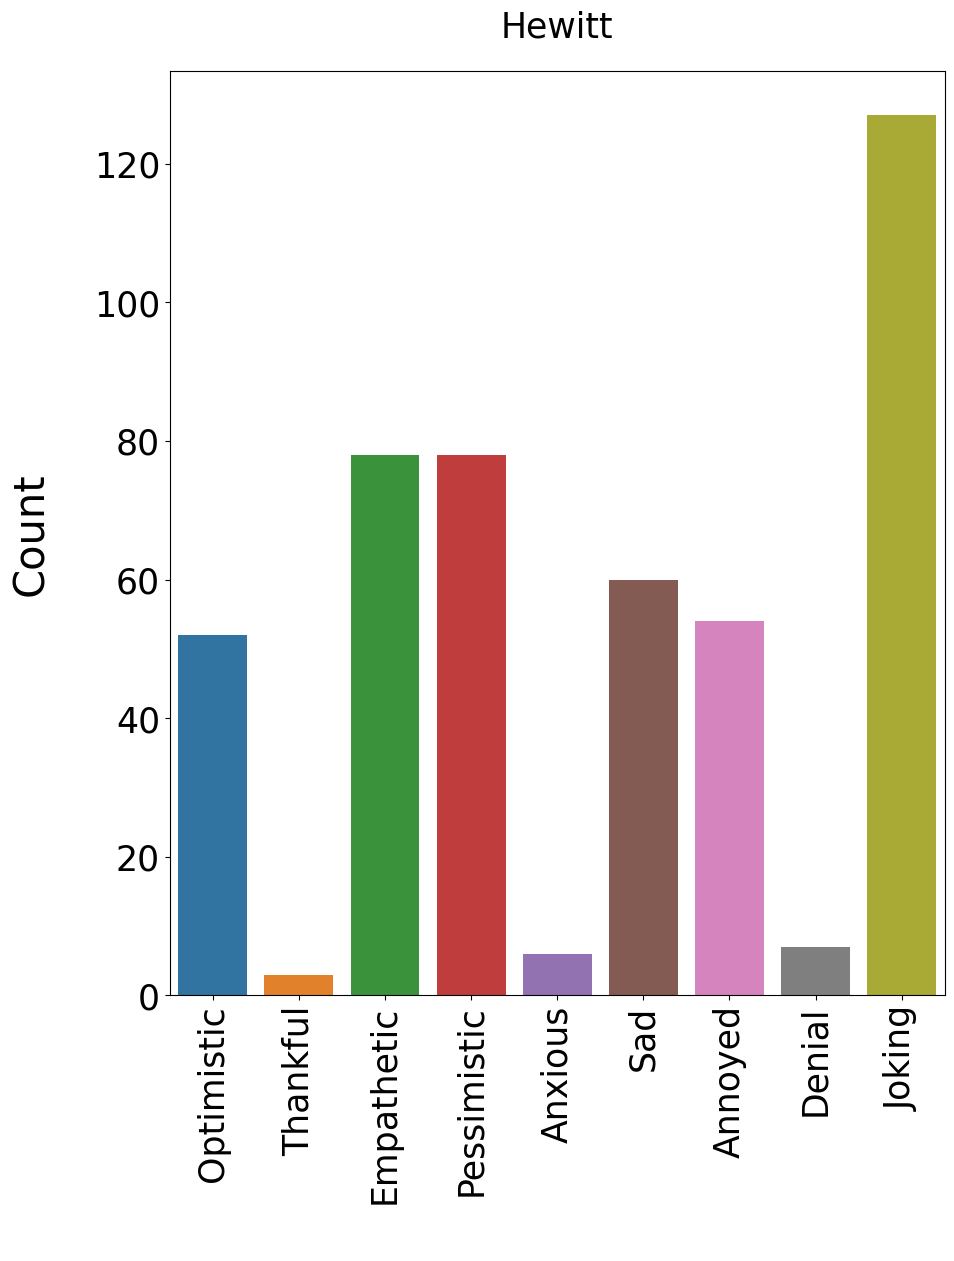

In [20]:
total_df = pd.DataFrame()
for poem in poem_names:
    df = pd.read_csv('results/poems/sentiment/' + 'en/' + poem)
    df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
    df = df.apply(pd.Series.value_counts)

    df['Optimistic'] = df['Optimistic'].fillna(0)
    df['Thankful'] = df['Thankful'].fillna(0)
    df['Empathetic'] = df['Empathetic'].fillna(0)
    df['Pessimistic'] = df['Pessimistic'].fillna(0)
    df['Anxious'] = df['Anxious'].fillna(0)
    df['Sad'] = df['Sad'].fillna(0)
    df['Annoyed'] = df['Annoyed'].fillna(0)
    df['Denial'] = df['Denial'].fillna(0)
    df['Joking'] = df['Joking'].fillna(0)    

    df = df.iloc[1]
    df = pd.DataFrame(df)
    df.columns = ['Count']
    total_df = pd.concat([total_df, df])

total_df = total_df.reset_index()
total_df = total_df.rename(columns={"index": "Sentiment"})

new_df = pd.DataFrame({
    "Sentiment":["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Joking"], 
    "Count":[0,0,0,0,0,0,0,0,0,]
})

for ii in range(0, 9):
  for jj in range(0, 15):
    new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df.loc[jj * 9 + ii, 'Count']).astype(int)

fig_dims = (10, 12)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x=new_df.Sentiment, y=new_df.Count, ax=ax, palette=sns.color_palette("tab10"))
plt.xticks(rotation=90)
plt.ylabel('Count', labelpad=30)
plt.xlabel(' ')
plt.title('Hewitt', fontsize=25, pad=25)
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.savefig('results/poems/graphs/sentiment_hewitt.png')

In [23]:
def all_chapter_dataframe(source):
    total_df = pd.DataFrame()
    for poem in poem_names:
        df = pd.read_csv('results/poems/sentiment/' + source + poem)
        df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
        df = df.apply(pd.Series.value_counts)

        df['Optimistic'] = df['Optimistic'].fillna(0)
        df['Thankful'] = df['Thankful'].fillna(0)
        df['Empathetic'] = df['Empathetic'].fillna(0)
        df['Pessimistic'] = df['Pessimistic'].fillna(0)
        df['Anxious'] = df['Anxious'].fillna(0)
        df['Sad'] = df['Sad'].fillna(0)
        df['Annoyed'] = df['Annoyed'].fillna(0)
        df['Denial'] = df['Denial'].fillna(0)
        df['Joking'] = df['Joking'].fillna(0)    

        df = df.iloc[1]
        df = pd.DataFrame(df)
        df.columns = ['Count']
        total_df = pd.concat([total_df, df])

    total_df = total_df.reset_index()
    total_df = total_df.rename(columns={"index": "Sentiment"})

    new_df = pd.DataFrame({
        "Sentiment":["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Joking"], 
        "Count":[0,0,0,0,0,0,0,0,0,]
    })

    for ii in range(0, 9):
        for jj in range(0, 15):
            new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df.loc[jj * 9 + ii, 'Count']).astype(int)
    
    return new_df

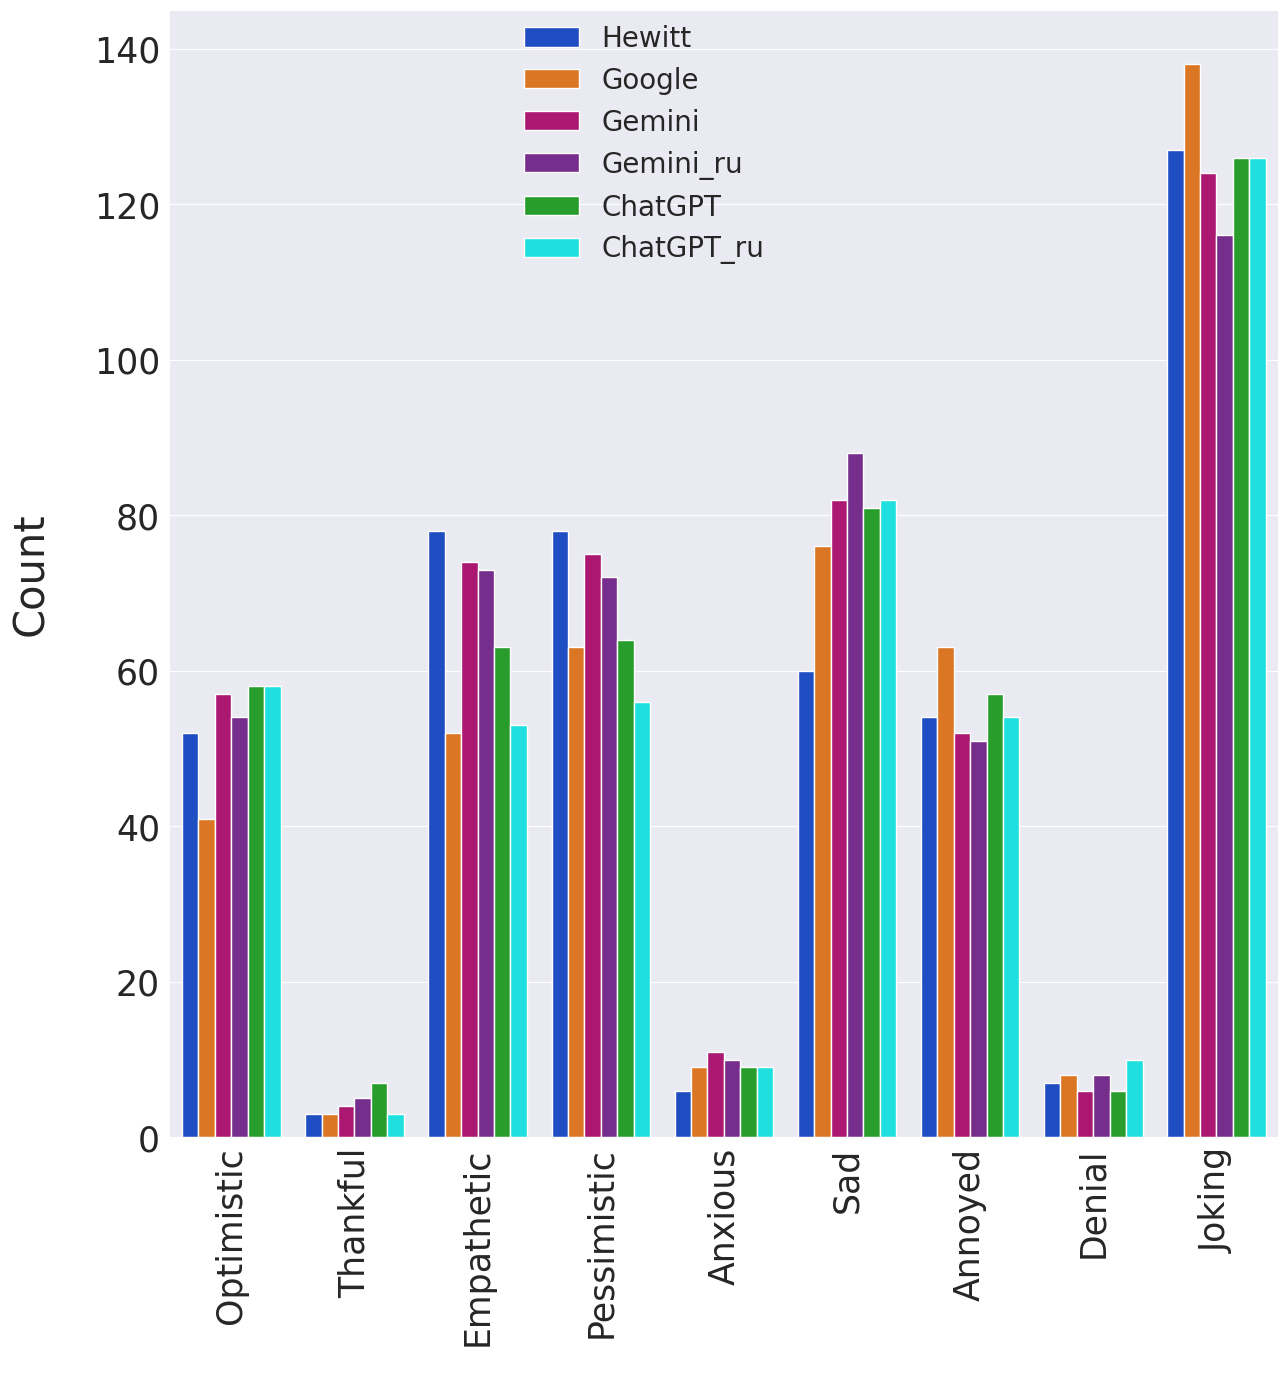

In [24]:
hewitt_sentiment = all_chapter_dataframe('en/')
google_sentiment = all_chapter_dataframe('ggl/')
gemini_sentiment = all_chapter_dataframe('gem/')
gemini_ru_sentiment = all_chapter_dataframe('gem_ru/')
chatgpt_sentiment = all_chapter_dataframe('gpt/')
chatgpt_ru_sentiment = all_chapter_dataframe('gpt_ru/')

df_new = pd.concat(
    [
        hewitt_sentiment, 
        google_sentiment['Count'], 
        gemini_sentiment['Count'], 
        gemini_ru_sentiment['Count'], 
        chatgpt_sentiment['Count'],
        chatgpt_ru_sentiment['Count']
    ],
    axis=1
)

df_new.columns = ['Sentiment', 'Hewitt', 'Google', 'Gemini', 'Gemini_ru', 'ChatGPT', 'ChatGPT_ru']
df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")
colors = ["blue", "orange", "magenta", "purple", "green", "cyan"]  
myPalette = sns.xkcd_palette(colors)

sns.set_style("darkgrid")
g = sns.catplot(x='Sentiment', y='Count', hue='Author', data=df_new, kind='bar', height=12, palette=myPalette, legend=True)
g.despine(left=True)
sns.move_legend(g, 'upper center', prop={"size": 20}, title='')
plt.ylabel('Count', labelpad=30, fontsize=30)
plt.xlabel(' ')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.yticks(fontsize= 25)
plt.xticks(fontsize = 25)
plt.xticks(rotation=90)
plt.savefig('results/poems/graphs/sentiment_all_ru.png')

In [25]:
def chapter_wise_dataframe(source, poem):
    df = pd.read_csv('results/poems/sentiment/' + source + poem)
    df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
    df = df.apply(pd.Series.value_counts)
    df['Optimistic'] = df['Optimistic'].fillna(0)
    df['Thankful'] = df['Thankful'].fillna(0)
    df['Empathetic'] = df['Empathetic'].fillna(0)
    df['Pessimistic'] = df['Pessimistic'].fillna(0)
    df['Anxious'] = df['Anxious'].fillna(0)
    df['Sad'] = df['Sad'].fillna(0)
    df['Annoyed'] = df['Annoyed'].fillna(0)
    df['Denial'] = df['Denial'].fillna(0)
    df['Joking'] = df['Joking'].fillna(0)
    df = df.iloc[1]
    df = pd.DataFrame(df)
    df.columns = ['Count']
    return df

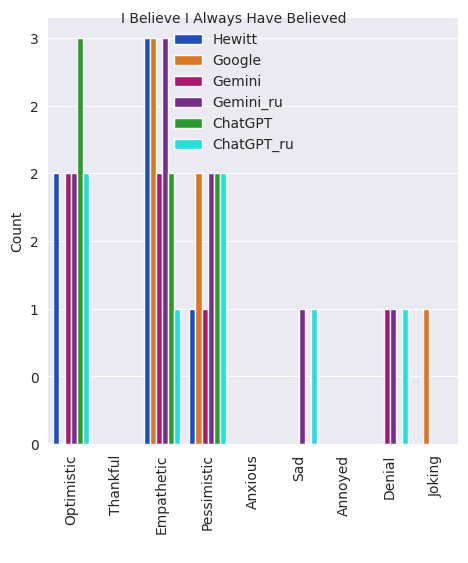

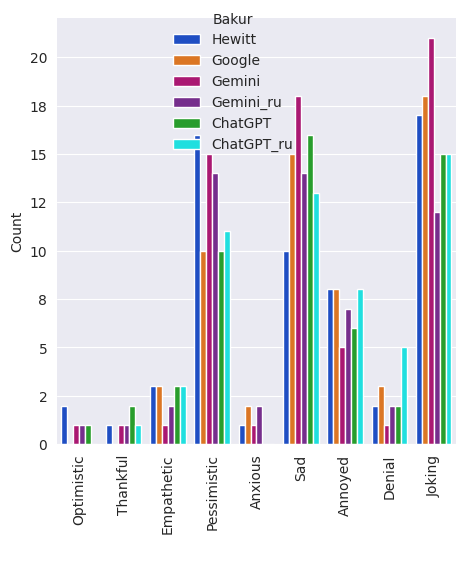

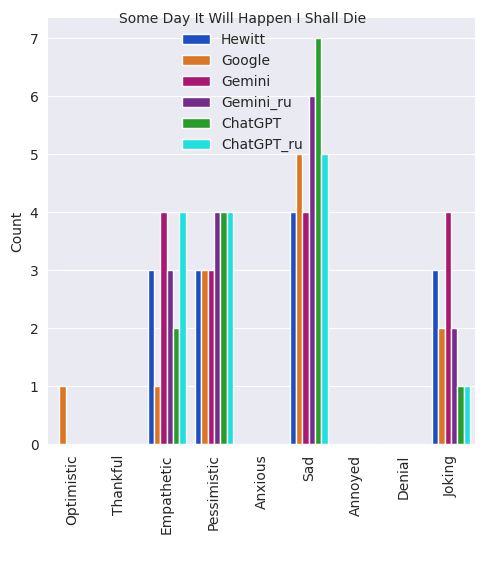

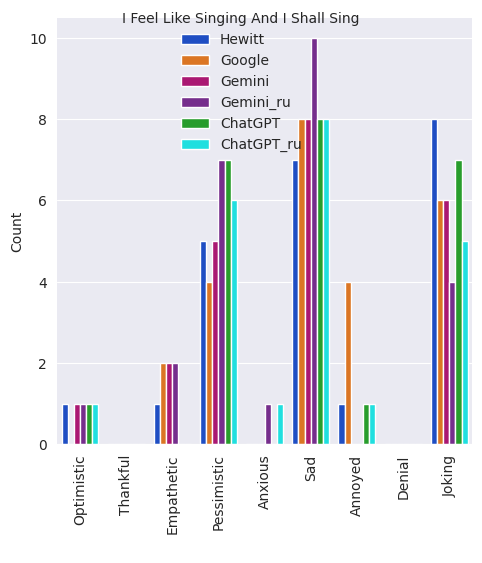

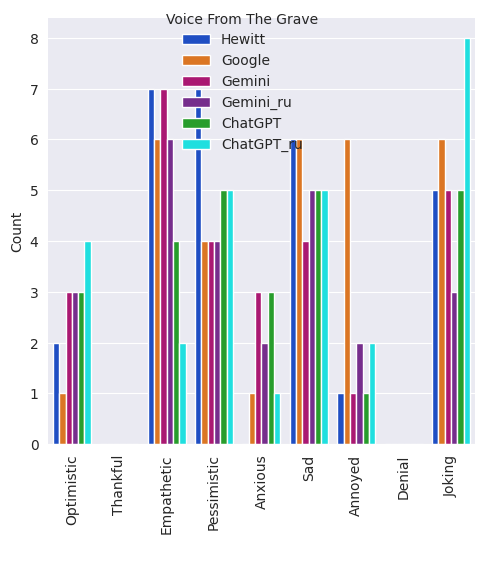

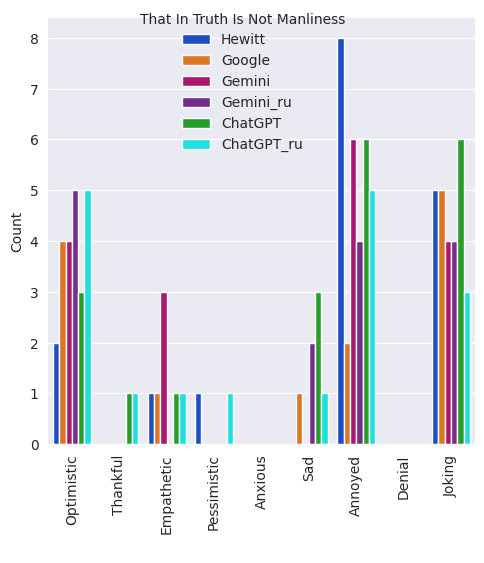

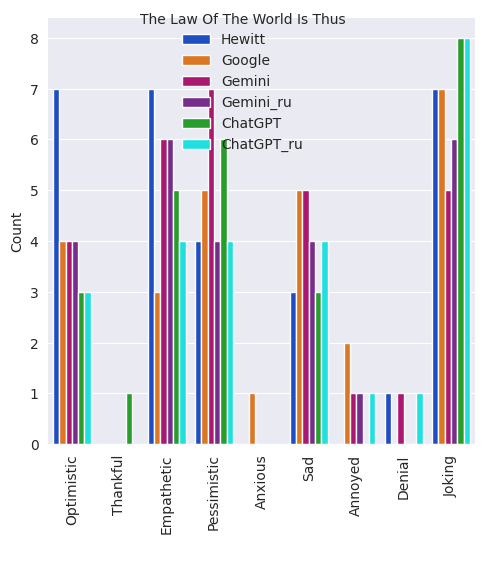

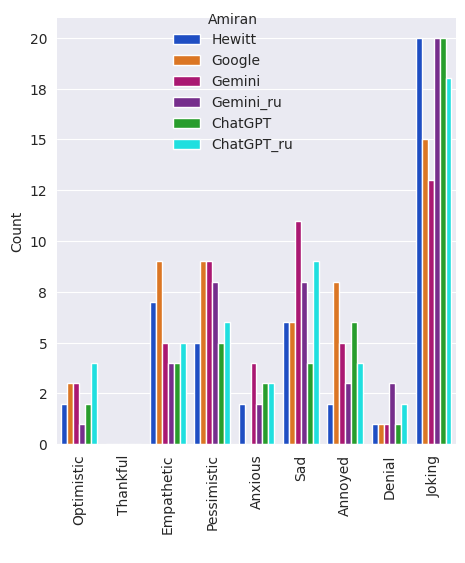

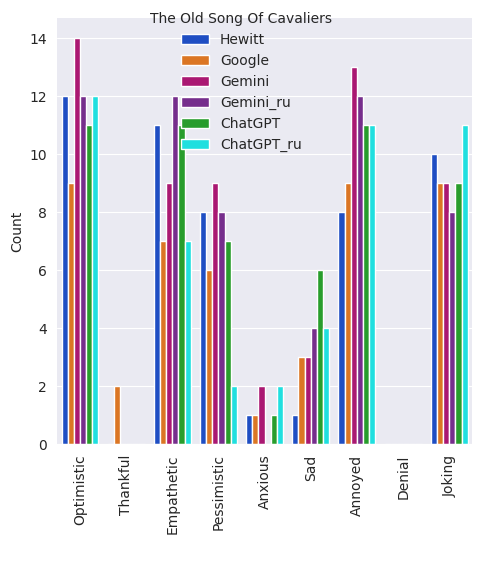

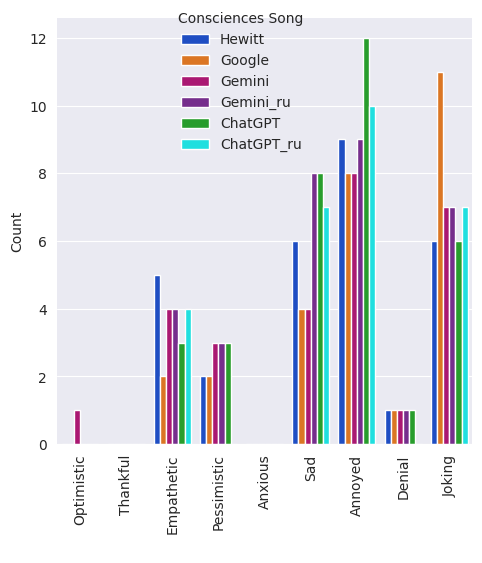

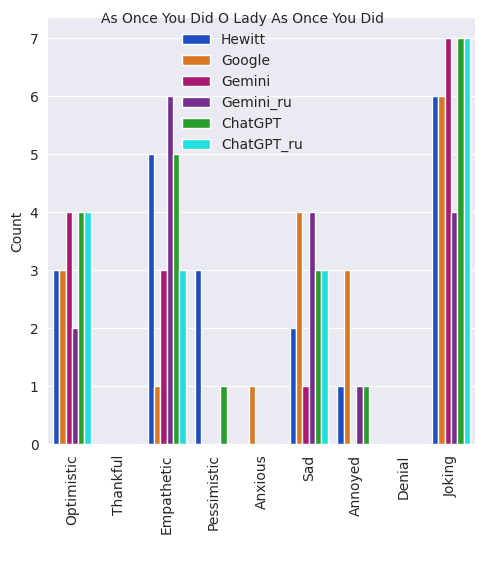

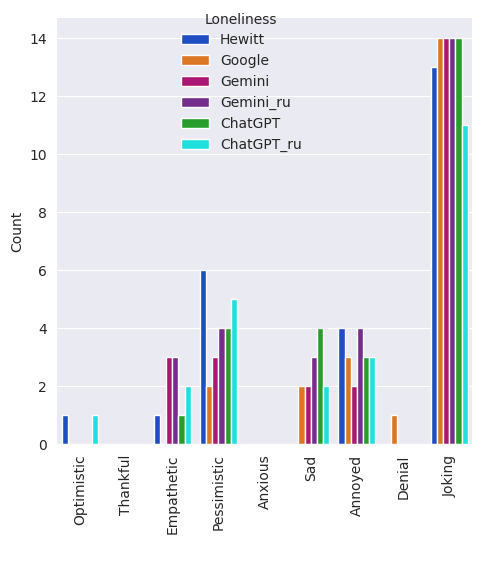

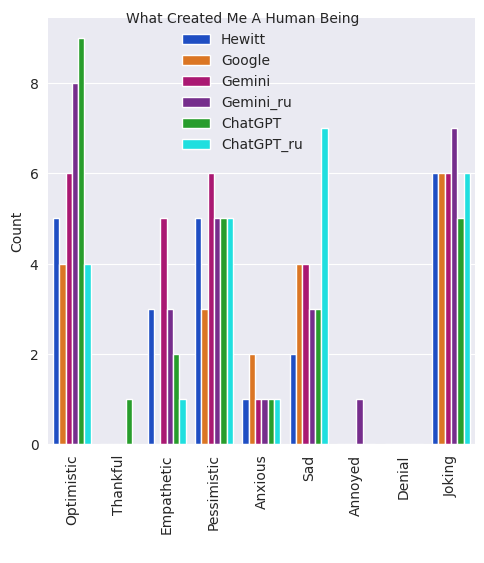

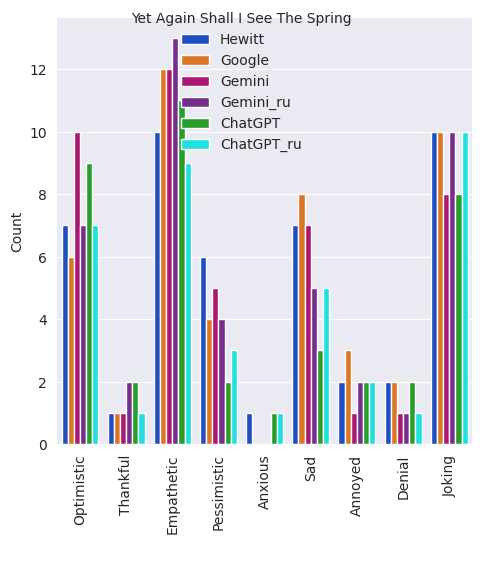

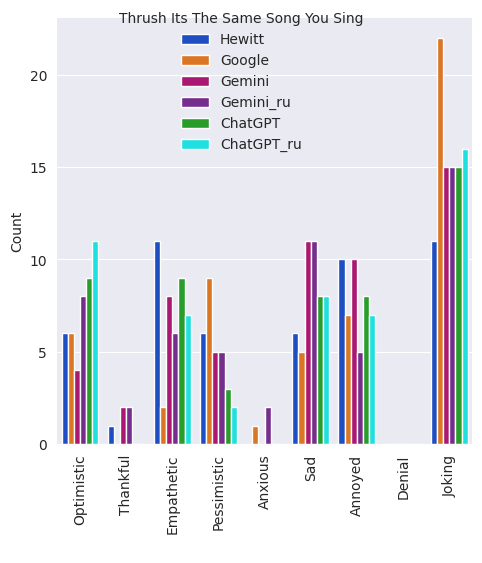

In [29]:
for poem in poem_names:
    hewitt_df = chapter_wise_dataframe('en/', poem)
    google_df = chapter_wise_dataframe('ggl/', poem)
    gemini_df = chapter_wise_dataframe('gem/', poem)
    gemini_ru_df = chapter_wise_dataframe('gem_ru/', poem)
    chatgpt_df =chapter_wise_dataframe('gpt/', poem)
    chatgpt_ru_df =chapter_wise_dataframe('gpt_ru/', poem)
    df_new = pd.concat(
        [
            hewitt_df, 
            google_df['Count'], 
            gemini_df['Count'], 
            gemini_ru_df['Count'], 
            chatgpt_df['Count'],
            chatgpt_ru_df['Count']
        ], 
        axis=1
    )

    df_new.columns = ['Hewitt', 'Google', 'Gemini', 'Gemini_ru', 'ChatGPT', 'ChatGPT_ru']
    df_new = df_new.reset_index()
    df_new = df_new.rename(columns={"index":"Sentiment"})
    df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")
    colors = ["blue", "orange", "magenta", "purple", "green", "cyan"]  
    myPalette = sns.xkcd_palette(colors)

    sns.set_style("darkgrid")
    g = sns.catplot(
        x='Sentiment', 
        y='Count', 
        hue='Author', 
        data=df_new, 
        kind='bar', 
        palette=myPalette, 
        legend=True
    )
    g.despine(left=True)

    sns.move_legend(g, 'upper center', title=poem[3:-3].replace('_', ' ').title())    
    plt.ylabel('Count')
    plt.xlabel(' ')
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.yticks()
    plt.xticks()
    plt.xticks(rotation=90)
    # plt.savefig('results/poems/graphs/' + poem[:-3] + '_ru.png')

In [30]:
df_new.head()

Sentiment  Author  Count
0   Optimistic  Hewitt    6.0
1     Thankful  Hewitt    1.0
2   Empathetic  Hewitt   11.0
3  Pessimistic  Hewitt    6.0
4      Anxious  Hewitt    0.0

In [31]:
df_new.reset_index()

index    Sentiment      Author  Count
0       0   Optimistic      Hewitt    6.0
1       1     Thankful      Hewitt    1.0
2       2   Empathetic      Hewitt   11.0
3       3  Pessimistic      Hewitt    6.0
4       4      Anxious      Hewitt    0.0
5       5          Sad      Hewitt    6.0
6       6      Annoyed      Hewitt   10.0
7       7       Denial      Hewitt    0.0
8       8       Joking      Hewitt   11.0
9       9   Optimistic      Google    6.0
10     10     Thankful      Google    0.0
11     11   Empathetic      Google    2.0
12     12  Pessimistic      Google    9.0
13     13      Anxious      Google    1.0
14     14          Sad      Google    5.0
15     15      Annoyed      Google    7.0
16     16       Denial      Google    0.0
17     17       Joking      Google   22.0
18     18   Optimistic      Gemini    4.0
19     19     Thankful      Gemini    2.0
20     20   Empathetic      Gemini    8.0
21     21  Pessimistic      Gemini    5.0
22     22      Anxious      Gemini    0.0
23     23          Sad      Gemini   11.0
24     24      Annoyed      Gemini   10.0
25     25       Denial      Gemini    0.0
26     26       Joking      Gemini   15.0
27     27   Optimistic   Gemini_ru    8.0
28     28     Thankful   Gemini_ru    2.0
29     29   Empathetic   Gemini_ru    6.0
30     30  Pessimistic   Gemini_ru    5.0
31     31      Anxious   Gemini_ru    2.0
32     32          Sad   Gemini_ru   11.0
33     33      Annoyed   Gemini_ru    5.0
34     34       Denial   Gemini_ru    0.0
35     35       Joking   Gemini_ru   15.0
36     36   Optimistic     ChatGPT    9.0
37     37     Thankful     ChatGPT    0.0
38     38   Empathetic     ChatGPT    9.0
39     39  Pessimistic     ChatGPT    3.0
40     40      Anxious     ChatGPT    0.0
41     41          Sad     ChatGPT    8.0
42     42      Annoyed     ChatGPT    8.0
43     43       Denial     ChatGPT    0.0
44     44       Joking     ChatGPT   15.0
45     45   Optimistic  ChatGPT_ru   11.0
46     46     Thankful  ChatGPT_ru    0.0
47     47   Empathetic  ChatGPT_ru    7.0
48     48  Pessimistic  ChatGPT_ru    2.0
49     49      Anxious  ChatGPT_ru    0.0
50     50          Sad  ChatGPT_ru    8.0
51     51      Annoyed  ChatGPT_ru    7.0
52     52       Denial  ChatGPT_ru    0.0
53     53       Joking  ChatGPT_ru   16.0

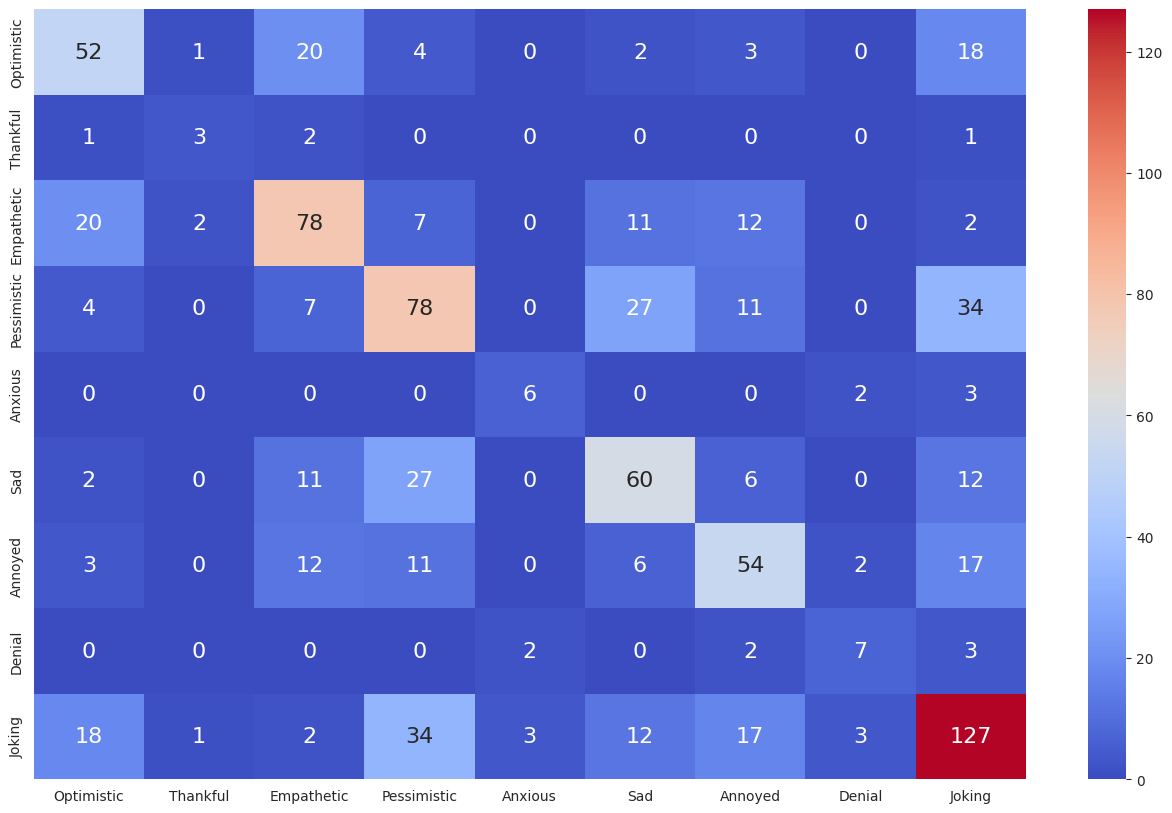

In [33]:
heatmap_df = pd.read_csv('results/poems/sentiment/en/' + poem_names[0])
heatmap_df = heatmap_df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)

for poem in poem_names[1:]:
  df = pd.read_csv('results/poems/sentiment/en/' + poem)
  df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
  heatmap_df = pd.concat([heatmap_df, df], axis=0)

emote_array = np.zeros((9, 9))
e2i = {'Optimistic': 0, 'Thankful': 1, 'Empathetic': 2, 'Pessimistic': 3, 'Anxious': 4, 'Sad': 5, 'Annoyed': 6, 'Denial': 7, 'Joking': 8}

for i in range(len(heatmap_df)):
    l = heatmap_df.iloc[i].tolist()
    for j in range(9):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 9):
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

emotions = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Joking']
emote_df = pd.DataFrame(emote_array, columns=emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)

fig = plt.figure(figsize = (16, 10))
sns.heatmap(emote_df, annot=True, cmap='coolwarm', xticklabels=emote_df.columns, yticklabels=emote_df.columns, fmt='g', annot_kws={"size": 16})
plt.savefig('results/poems/graphs/heatmap_ru.png')

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Optimistic'),
  Text(1, 0, 'Thankful'),
  Text(2, 0, 'Empathetic'),
  Text(3, 0, 'Pessimistic'),
  Text(4, 0, 'Anxious'),
  Text(5, 0, 'Sad'),
  Text(6, 0, 'Annoyed'),
  Text(7, 0, 'Denial'),
  Text(8, 0, 'Joking')])

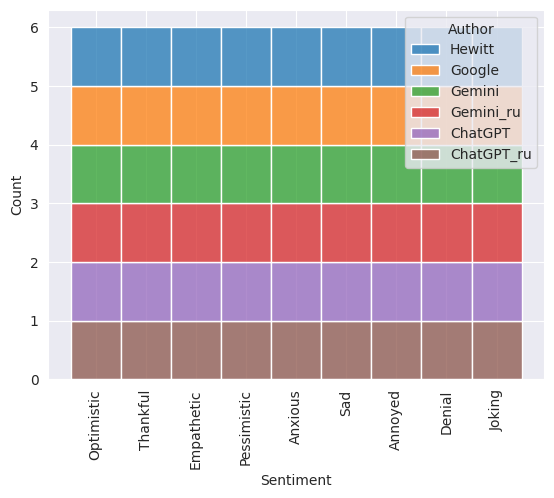

In [34]:
hewitt_sentiment = all_chapter_dataframe('en/')
google_sentiment = all_chapter_dataframe('ggl/')
gemini_sentiment = all_chapter_dataframe('gem/')
gemini_ru_sentiment = all_chapter_dataframe('gem_ru/')
chatgpt_sentiment = all_chapter_dataframe('gpt/')
chatgpt_ru_sentiment = all_chapter_dataframe('gpt_ru/')

df_new = pd.concat([
        hewitt_sentiment, 
        google_sentiment['Count'], 
        gemini_sentiment['Count'], 
        gemini_ru_sentiment['Count'], 
        chatgpt_sentiment['Count'],
        chatgpt_ru_sentiment['Count']
    ], 
    axis=1
)
df_new.columns = ['Sentiment', 'Hewitt', 'Google', 'Gemini', 'Gemini_ru', 'ChatGPT', 'ChatGPT_ru'] 
df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")
sns.histplot(data=df_new, x='Sentiment', hue='Author', multiple='stack')
plt.xticks(rotation=90)

In [35]:
df_new.head()

Sentiment  Author  Count
0   Optimistic  Hewitt     52
1     Thankful  Hewitt      3
2   Empathetic  Hewitt     78
3  Pessimistic  Hewitt     78
4      Anxious  Hewitt      6

In [38]:
hewitt_poem_01 = pd.read_csv('results/poems/sentiment/en/' + poem_names[0])
google_poem_01 = pd.read_csv('results/poems/sentiment/ggl/' + poem_names[0])
gemini_poem_01 = pd.read_csv('results/poems/sentiment/gem/' + poem_names[0])
gemini_ru_poem_01 = pd.read_csv('results/poems/sentiment/gem_ru/' + poem_names[0])
chatgpt_poem_01 = pd.read_csv('results/poems/sentiment/gpt/' + poem_names[0])
chatgpt_ru_poem_01 = pd.read_csv('results/poems/sentiment/gpt_ru/' + poem_names[0])

hewitt_poem_01_short = hewitt_poem_01.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
google_poem_01_short = google_poem_01.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
gemini_poem_01_short = gemini_poem_01.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
gemini_ru_poem_01_short = gemini_poem_01.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
chatgpt_poem_01_short = chatgpt_poem_01.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
chatgpt_ru_poem_01_short = chatgpt_poem_01.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)

In [39]:
hewitt_poem_01

Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   

                                                                                                                                              Tweet  \
0      I believe, I always have believed In the eternal life of the soul, The good, the lover of the world, Scarred by the fate of this same world.   
1  I believe that, though the ashes of kind hearts Be scattered over the land by the wind, Yet in each of us there will burn Hotly a wish forlorn —   
2                        To repress evil, and that this Will ever be a defence of the good, Help, succour and saviour Of the downtrodden and needy.   
3                                        Nature does not totally extinguish a kind heart, She carries it along with her from the very dawn of time.   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
1         0.0       0.0         1.0          0.0      0.0  0.0      0.0   
2         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
3         0.0       0.0         0.0          1.0      0.0  0.0      0.0   

   Denial  Official report  Joking  
0     0.0              0.0     0.0  
1     0.0              0.0     0.0  
2     0.0              0.0     0.0  
3     0.0              0.0     0.0

In [40]:
google_poem_01

Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   

                                                                                                                                Tweet  \
0                I believe, there are always lands eternal life of the soul, Good, country lover, Ulcer from the fate of the country.   
1  I believe that ashes are the heart of a good person Let the wind scatter the land, It still burns in itself Tial-desire was hot, –   
2                                 Evil oppressor, good There will always be a guard; Bechav, needy He helped me, helped me, saved me.   
3                                                                       Nature does not kill a good heart Brings old things with him!   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         0.0       0.0         1.0          0.0      0.0  0.0      0.0   
1         0.0       0.0         1.0          1.0      0.0  0.0      0.0   
2         0.0       0.0         1.0          0.0      0.0  0.0      0.0   
3         0.0       0.0         0.0          1.0      0.0  0.0      0.0   

   Denial  Official report  Joking  
0     0.0              0.0     0.0  
1     0.0              0.0     0.0  
2     0.0              0.0     0.0  
3     0.0              0.0     1.0

In [41]:
gemini_poem_01

Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   

                                                                                                                                            Tweet  \
0   I believe, I've always believed In the eternal life of the soul, Of the good, the lover of the country, The one pained by the country's fate.   
1  I believe, even when the ashes Of a good heart are scattered by the wind, Within each one, a spark still ignites, A burning desire for warmth.   
2                 To suppress evil, to protect the good, It will always be a guardian; For the poor, the troubled, A helper, a savior, a rescuer.   
3                                                                   Nature does not kill a good heart, It carries it along, from time immemorial!   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         0.0       0.0         1.0          0.0      0.0  0.0      0.0   
1         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
2         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
3         0.0       0.0         0.0          1.0      0.0  0.0      0.0   

   Denial  Official report  Joking  
0     0.0              0.0     0.0  
1     0.0              0.0     0.0  
2     0.0              0.0     0.0  
3     1.0              0.0     0.0

In [42]:
chatgpt_poem_01

Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   

                                                                                                                                                        Tweet  \
0  I believe, I have always believed in the eternal life of the soul, of the good, the lover of the homeland, the one suffering from the fate of the country.   
1                              I believe, that even if the ashes of a good heart are scattered by the wind, they will still ignite a burning desire within, —   
2                       as the protector against evil, the good will always be a guardian; for the helpless, the downtrodden a helper, a supporter, a savior.   
3                                                                                   Nature does not kill a good heart, it carries the wisdom of the ancients!   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
1         0.0       0.0         0.0          1.0      0.0  0.0      0.0   
2         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
3         1.0       0.0         0.0          1.0      0.0  0.0      0.0   

   Denial  Official report  Joking  
0     0.0              0.0     0.0  
1     0.0              0.0     0.0  
2     0.0              0.0     0.0  
3     0.0              0.0     0.0

In [43]:
y_true = np.array([[0, 1, 1],
                   [1, 1, 0]])
y_pred = np.array([[1, 1, 1],
                   [1, 0, 0]])

In [44]:
for ii in range(0, hewitt_poem_01_short.shape[0]):
    print(jaccard_score(google_poem_01_short.iloc[ii, :], hewitt_poem_01_short.iloc[ii, :]))

0.5
0.5
0.5
0.5


In [45]:
hewitt_ggl_df = pd.DataFrame()
hewitt_gem_df = pd.DataFrame()
hewitt_gem_ru_df = pd.DataFrame()
hewitt_gpt_df = pd.DataFrame()
hewitt_gpt_ru_df = pd.DataFrame()

poem_list = []
hewitt_ggl_lst = []
hewitt_gem_lst = []
hewitt_gem_ru_lst = []
hewitt_gpt_lst = []
hewitt_gpt_ru_lst = []

ggl = []
gem = []
gem_ru = []
gpt = []
gpt_ru = []

sum1 = 0
sum2 = 0
sum3 = 0
sum4 = 0
sum5 = 0

for poem in poem_names:
    hewitt_df = pd.read_csv('results/poems/sentiment/' + 'en/' + poem)
    google_df = pd.read_csv('results/poems/sentiment/' + 'ggl/' + poem)
    gemini_df = pd.read_csv('results/poems/sentiment/' + 'gem/' + poem)
    gemini_ru_df = pd.read_csv('results/poems/sentiment/' + 'gem_ru/' + poem)
    chatgpt_df = pd.read_csv('results/poems/sentiment/' + 'gpt/' + poem)
    chatgpt_ru_df = pd.read_csv('results/poems/sentiment/' + 'gpt_ru/' + poem)

    hewitt_df = hewitt_df.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
    google_df = google_df.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
    gemini_df = gemini_df.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
    gemini_ru_df = gemini_ru_df.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
    chatgpt_df = chatgpt_df.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
    chatgpt_ru_df = chatgpt_ru_df.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)

    for ii in range(0, hewitt_df.shape[0]):
        hewitt_ggl_lst.append(jaccard_score(hewitt_df.iloc[ii, :], google_df.iloc[ii, :]))
        hewitt_gem_lst.append(jaccard_score(hewitt_df.iloc[ii, :], gemini_df.iloc[ii, :]))
        hewitt_gem_ru_lst.append(jaccard_score(hewitt_df.iloc[ii, :], gemini_ru_df.iloc[ii, :]))
        hewitt_gpt_lst.append(jaccard_score(hewitt_df.iloc[ii, :], chatgpt_df.iloc[ii, :]))
        hewitt_gpt_ru_lst.append(jaccard_score(hewitt_df.iloc[ii, :], chatgpt_ru_df.iloc[ii, :]))

    poem_list.append(poem)

    hewitt_ggl_df1 = pd.DataFrame(poem_list, columns=['Poem'])
    hewitt_ggl_df2 = pd.DataFrame(hewitt_ggl_lst, columns=['Hewitt - Google'])
    hewitt_ggl_df  = pd.concat([hewitt_ggl_df1, hewitt_ggl_df2], axis=1)

    hewitt_gem_df1 = pd.DataFrame(poem_list, columns=['Poem'])
    hewitt_gem_df2 = pd.DataFrame(hewitt_gem_lst, columns=['Hewitt - Gemini'])
    hewitt_gem_df  = pd.concat([hewitt_gem_df1, hewitt_gem_df2], axis=1)

    hewitt_gem_ru_df1 = pd.DataFrame(poem_list, columns=['Poem'])
    hewitt_gem_ru_df2 = pd.DataFrame(hewitt_gem_ru_lst, columns=['Hewitt - Gemini_ru'])
    hewitt_gem_ru_df  = pd.concat([hewitt_gem_ru_df1, hewitt_gem_ru_df2], axis=1)

    hewitt_gpt_df1 = pd.DataFrame(poem_list, columns=['Poem'])
    hewitt_gpt_df2 = pd.DataFrame(hewitt_gpt_lst, columns=['Hewitt - ChatGPT'])
    hewitt_gpt_df  = pd.concat([hewitt_gpt_df1, hewitt_gpt_df2], axis=1)    

    hewitt_gpt_ru_df1 = pd.DataFrame(poem_list, columns=['Poem'])
    hewitt_gpt_ru_df2 = pd.DataFrame(hewitt_gpt_ru_lst, columns=['Hewitt - ChatGPT_ru'])
    hewitt_gpt_ru_df  = pd.concat([hewitt_gpt_ru_df1, hewitt_gpt_ru_df2], axis=1) 

    ggl.append(hewitt_ggl_df['Hewitt - Google'].mean())
    hewitt_ggl_df3 = pd.DataFrame(ggl, columns=['Hewitt - Google'])
    hewitt_ggl_df4 = pd.concat([hewitt_ggl_df1, hewitt_ggl_df3], axis=1)

    gem.append(hewitt_gem_df['Hewitt - Gemini'].mean())
    hewitt_gem_df3 = pd.DataFrame(gem, columns=['Hewitt - Gemini'])
    hewitt_gem_df4 = pd.concat([hewitt_gem_df1, hewitt_gem_df3], axis=1)

    gem_ru.append(hewitt_gem_ru_df['Hewitt - Gemini_ru'].mean())
    hewitt_gem_ru_df3 = pd.DataFrame(gem_ru, columns=['Hewitt - Gemini_ru'])
    hewitt_gem_ru_df4 = pd.concat([hewitt_gem_ru_df1, hewitt_gem_ru_df3], axis=1)

    gpt.append(hewitt_gpt_df['Hewitt - ChatGPT'].mean())
    hewitt_gpt_df3 = pd.DataFrame(gpt, columns=['Hewitt - ChatGPT'])
    hewitt_gpt_df4 = pd.concat([hewitt_gpt_df1, hewitt_gpt_df3], axis=1)

    gpt_ru.append(hewitt_gpt_ru_df['Hewitt - ChatGPT_ru'].mean())
    hewitt_gpt_ru_df3 = pd.DataFrame(gpt_ru, columns=['Hewitt - ChatGPT_ru'])
    hewitt_gpt_ru_df4 = pd.concat([hewitt_gpt_ru_df1, hewitt_gpt_ru_df3], axis=1)

    print('Poem "', str(poem[3:-3].replace('_', ' ').title()), '" Average')
    print('Hewitt - Google ', hewitt_ggl_df['Hewitt - Google'].mean())
    print('Hewitt - Gemini ', hewitt_gem_df['Hewitt - Gemini'].mean())
    print('Hewitt - Gemini_ru ', hewitt_gem_ru_df['Hewitt - Gemini_ru'].mean())
    print('Hewitt - ChatGPT ', hewitt_gpt_df['Hewitt - ChatGPT'].mean())
    print('Hewitt - ChatGPT_ru ', hewitt_gpt_ru_df['Hewitt - ChatGPT_ru'].mean())
    print('\n')

    sum1 += hewitt_ggl_df['Hewitt - Google'].mean()
    sum2 += hewitt_gem_df['Hewitt - Gemini'].mean()
    sum3 += hewitt_gem_ru_df['Hewitt - Gemini_ru'].mean()
    sum4 += hewitt_gpt_df['Hewitt - ChatGPT'].mean()    
    sum5 += hewitt_gpt_ru_df['Hewitt - ChatGPT_ru'].mean()


Poem " I Believe I Always Have Believed " Average
Hewitt - Google  0.5
Hewitt - Gemini  0.5
Hewitt - Gemini_ru  0.7083333333333333
Hewitt - ChatGPT  0.625
Hewitt - ChatGPT_ru  0.5


Poem " Bakur " Average
Hewitt - Google  0.47916666666666663
Hewitt - Gemini  0.5229166666666666
Hewitt - Gemini_ru  0.4583333333333333
Hewitt - ChatGPT  0.5270833333333333
Hewitt - ChatGPT_ru  0.5208333333333333


Poem " Some Day It Will Happen I Shall Die " Average
Hewitt - Google  0.4829931972789115
Hewitt - Gemini  0.5425170068027211
Hewitt - Gemini_ru  0.46938775510204084
Hewitt - ChatGPT  0.5391156462585034
Hewitt - ChatGPT_ru  0.49319727891156456


Poem " I Feel Like Singing And I Shall Sing " Average
Hewitt - Google  0.5317460317460317
Hewitt - Gemini  0.5648148148148148
Hewitt - Gemini_ru  0.48412698412698413
Hewitt - ChatGPT  0.5515873015873016
Hewitt - ChatGPT_ru  0.5079365079365079


Poem " Voice From The Grave " Average
Hewitt - Google  0.5205761316872427
Hewitt - Gemini  0.5833333333333334
Hewi

In [46]:
sum1 = sum1 / len(poem_names)
sum2 = sum2 / len(poem_names)
sum3 = sum3 / len(poem_names)
sum4 = sum4 / len(poem_names)
sum5 = sum5 / len(poem_names)

print('sum1 ', sum1)
print('sum2 ', sum2)
print('sum3 ', sum3)
print('sum4 ', sum4)
print('sum5 ', sum5)

sum1  0.47233395041976944
sum2  0.5380971142672676
sum3  0.515088083592283
sum4  0.5454796730139974
sum5  0.5073642975160967


In [47]:
hewitt_ggl_df1 = pd.DataFrame(poem_list, columns=['Poem'])
hewitt_ggl_df2 = pd.DataFrame(hewitt_ggl_df4, columns=['Hewitt - Google'])
hewitt_ggl_df = pd.concat([hewitt_ggl_df1, hewitt_ggl_df2], axis=1)
hewitt_ggl_df

Poem  Hewitt - Google
0         01_i_believe_i_always_have_believed.md         0.500000
1                                    02_bakur.md         0.479167
2      03_some_day_it_will_happen_i_shall_die.md         0.482993
3     04_i_feel_like_singing_and_i_shall_sing.md         0.531746
4                     05_voice_from_the_grave.md         0.520576
5           06_that_in_truth_is_not_manliness.md         0.492674
6             07_the_law_of_the_world_is_thus.md         0.487654
7                                   08_amiran.md         0.443452
8                09_the_old_song_of_cavaliers.md         0.451183
9                         10_consciences_song.md         0.443100
10  11_as_once_you_did_o_lady_as_once_you_did.md         0.446549
11                              12_loneliness.md         0.457364
12           13_what_created_me_a_human_being.md         0.454348
13        14_yet_again_shall_i_see_the_spring.md         0.452335
14       15_thrush_its_the_same_song_you_sing.md         0.441867

In [48]:
df_final = pd.concat([
        hewitt_ggl_df, 
        hewitt_gem_df3['Hewitt - Gemini'], 
        hewitt_gem_ru_df3['Hewitt - Gemini_ru'], 
        hewitt_gpt_df3['Hewitt - ChatGPT'],
        hewitt_gpt_ru_df3['Hewitt - ChatGPT_ru']
    ], 
    axis=1
)
df_final

Poem  Hewitt - Google  \
0         01_i_believe_i_always_have_believed.md         0.500000   
1                                    02_bakur.md         0.479167   
2      03_some_day_it_will_happen_i_shall_die.md         0.482993   
3     04_i_feel_like_singing_and_i_shall_sing.md         0.531746   
4                     05_voice_from_the_grave.md         0.520576   
5           06_that_in_truth_is_not_manliness.md         0.492674   
6             07_the_law_of_the_world_is_thus.md         0.487654   
7                                   08_amiran.md         0.443452   
8                09_the_old_song_of_cavaliers.md         0.451183   
9                         10_consciences_song.md         0.443100   
10  11_as_once_you_did_o_lady_as_once_you_did.md         0.446549   
11                              12_loneliness.md         0.457364   
12           13_what_created_me_a_human_being.md         0.454348   
13        14_yet_again_shall_i_see_the_spring.md         0.452335   
14       15_thrush_its_the_same_song_you_sing.md         0.441867   

    Hewitt - Gemini  Hewitt - Gemini_ru  Hewitt - ChatGPT  Hewitt - ChatGPT_ru  
0          0.500000            0.708333          0.625000             0.500000  
1          0.522917            0.458333          0.527083             0.520833  
2          0.542517            0.469388          0.539116             0.493197  
3          0.564815            0.484127          0.551587             0.507937  
4          0.583333            0.513374          0.562757             0.520988  
5          0.555861            0.489011          0.539744             0.493956  
6          0.554012            0.501543          0.536574             0.496451  
7          0.537500            0.530357          0.540714             0.518690  
8          0.540434            0.507890          0.527811             0.504635  
9          0.532258            0.505376          0.534677             0.493459  
10         0.532828            0.503367          0.540152             0.499747  
11         0.539147            0.523256          0.548992             0.520310  
12         0.521377            0.515942          0.535652             0.511014  
13         0.527562            0.514591          0.538716             0.517964  
14         0.516896            0.501432          0.533620             0.511283

In [49]:
hewitt_ggl_avg_score = df_final['Hewitt - Google'].mean()
hewitt_gem_avg_score = df_final['Hewitt - Gemini'].mean()
hewitt_gem_ru_avg_score = df_final['Hewitt - Gemini_ru'].mean()
hewitt_gpt_avg_score = df_final['Hewitt - ChatGPT'].mean()
hewitt_gpt_ru_avg_score = df_final['Hewitt - ChatGPT_ru'].mean()

print(hewitt_ggl_avg_score)
print(hewitt_gem_avg_score)
print(hewitt_gem_ru_avg_score)
print(hewitt_gpt_avg_score)
print(hewitt_gpt_ru_avg_score)

0.47233395041976944
0.5380971142672676
0.515088083592283
0.5454796730139974
0.5073642975160967


In [50]:
data = pd.melt(df_final, ['Poem'])
data

Poem             variable  \
0         01_i_believe_i_always_have_believed.md      Hewitt - Google   
1                                    02_bakur.md      Hewitt - Google   
2      03_some_day_it_will_happen_i_shall_die.md      Hewitt - Google   
3     04_i_feel_like_singing_and_i_shall_sing.md      Hewitt - Google   
4                     05_voice_from_the_grave.md      Hewitt - Google   
..                                           ...                  ...   
70  11_as_once_you_did_o_lady_as_once_you_did.md  Hewitt - ChatGPT_ru   
71                              12_loneliness.md  Hewitt - ChatGPT_ru   
72           13_what_created_me_a_human_being.md  Hewitt - ChatGPT_ru   
73        14_yet_again_shall_i_see_the_spring.md  Hewitt - ChatGPT_ru   
74       15_thrush_its_the_same_song_you_sing.md  Hewitt - ChatGPT_ru   

       value  
0   0.500000  
1   0.479167  
2   0.482993  
3   0.531746  
4   0.520576  
..       ...  
70  0.499747  
71  0.520310  
72  0.511014  
73  0.517964  
74  0.511283  

[75 rows x 3 columns]

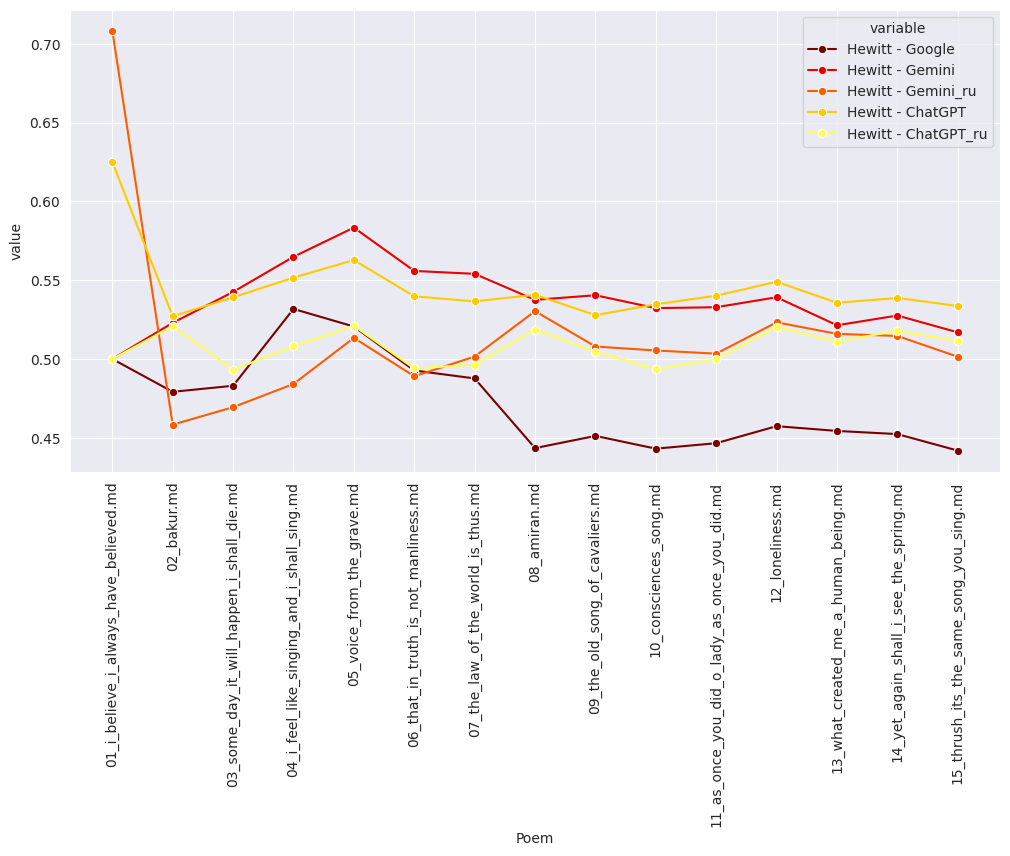

In [51]:
sns.set_style("darkgrid")
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(x='Poem', y='value', hue = 'variable', data=data, palette='hot', dashes=False, marker='o', ax=ax)
plt.xticks(rotation=90)
plt.savefig('results/poems/graphs/jaccard_all_ru.png')

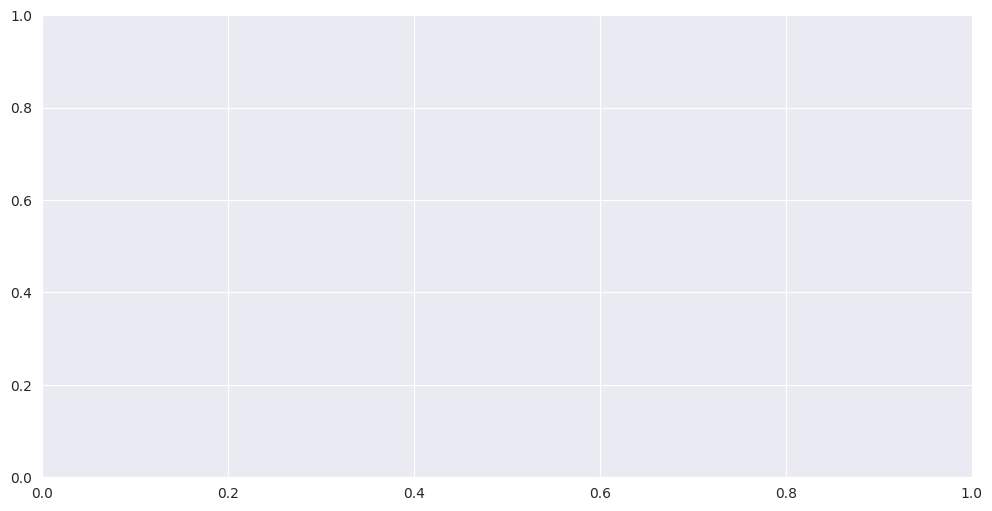

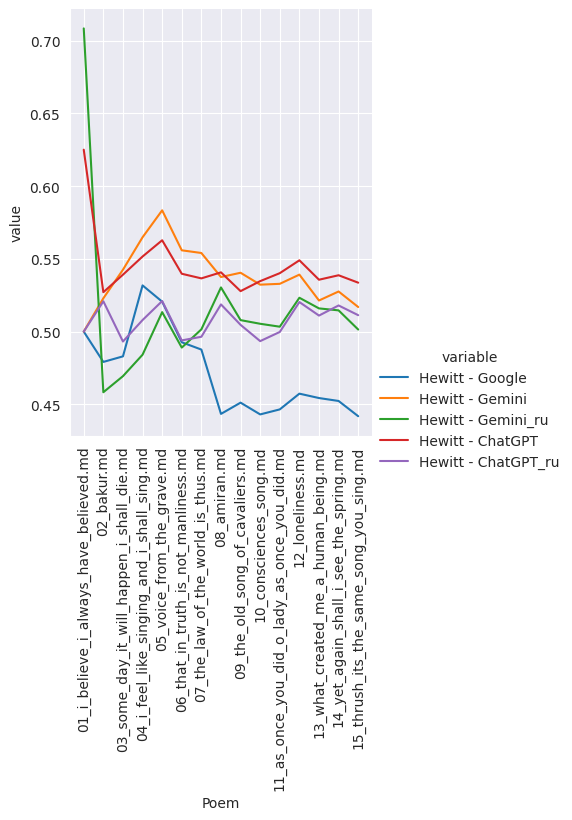

In [52]:
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.relplot(x="Poem", y="value", hue="variable", dashes=False, markers=True, kind="line", data=data)
plt.xticks(rotation=90)
plt.savefig('results/poems/graphs/jaccard_line_all_ru.png')

In [53]:
sentiment_polarity = {
    # 'Surprise': 0,
    'Joking': 0,
    'Pessimistic': -1,
    'Anxious': -1,
    'Sad':  -1,
    'Annoyed': -1,
    'Denial': -1,
    'Optimistic': 1,
    'Thankful': 1,
    'Empathetic': 1
}

In [54]:
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
init_notebook_mode(connected=False)
warnings.filterwarnings("ignore")

In [55]:
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']

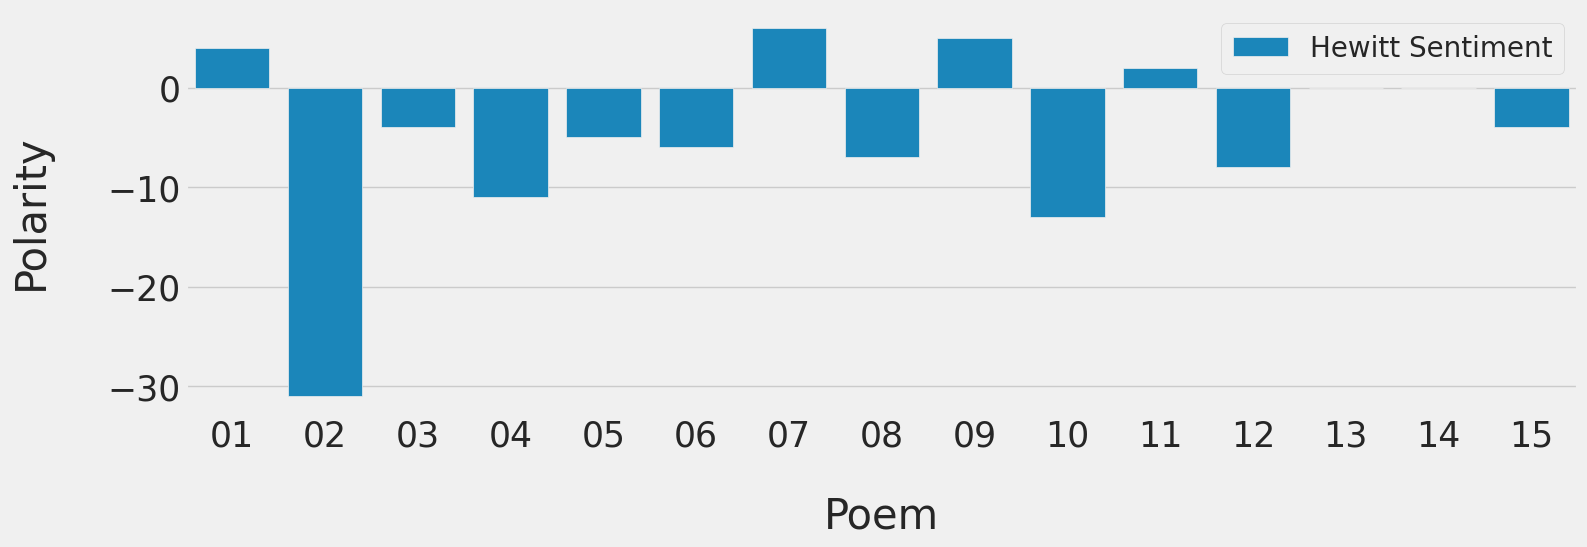

In [58]:
polarity = 0
count = 0
polarity_array = []
df_sentiments = pd.DataFrame(columns=['Poem', 'Polarity'])

for poem in poem_names:
    df_poem = pd.read_csv('results/poems/sentiment/' + 'en/' + poem)
    polarity = 0
    for i, row in df_poem.iterrows():
        if row['Optimistic'] == 1:
            count += 1
            polarity += 1
        if row['Thankful'] == 1:
            count += 1
            polarity += 1
        if row['Empathetic'] == 1:
            count += 1
            polarity += 1
        if row['Denial'] == 1:
            count += 1
            polarity -= 1 
        if row['Annoyed'] == 1:
            count += 1
            polarity -= 1
        if row['Sad'] == 1:
            count += 1
            polarity -= 1
        if row['Anxious'] == 1:
            count += 1
            polarity -= 1
        if row['Pessimistic'] == 1:
            count += 1
            polarity -= 1
        if row['Joking'] == 1:
            polarity += 0

    df_temp = pd.DataFrame([[poem[:2], polarity]], columns = ['Poem', 'Polarity'])
    df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index=True)

df_sentiments = df_sentiments.sort_values('Poem')
df_sentiments.reset_index()
df_sentiments.set_index('Poem')

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16, 5))
p6 = sns.barplot(x=df_sentiments['Poem'], y=df_sentiments['Polarity'], label='Hewitt Sentiment')
p6.set_xlabel("Hewitt Sentiment")
plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Poem', labelpad=30, fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(np.arange(0, 15, step=1), fontsize=25)
# plt.xticks(rotation=90)
plt.savefig('results/poems/graphs/hewitt_polarity.png')

In [59]:
def flatten(lst):
    new_list = []
    for sublist in lst:
      if isinstance(sublist, list):
        for item in sublist:
          new_list.append(item)
      else:
        new_list.append(sublist)
    return new_list

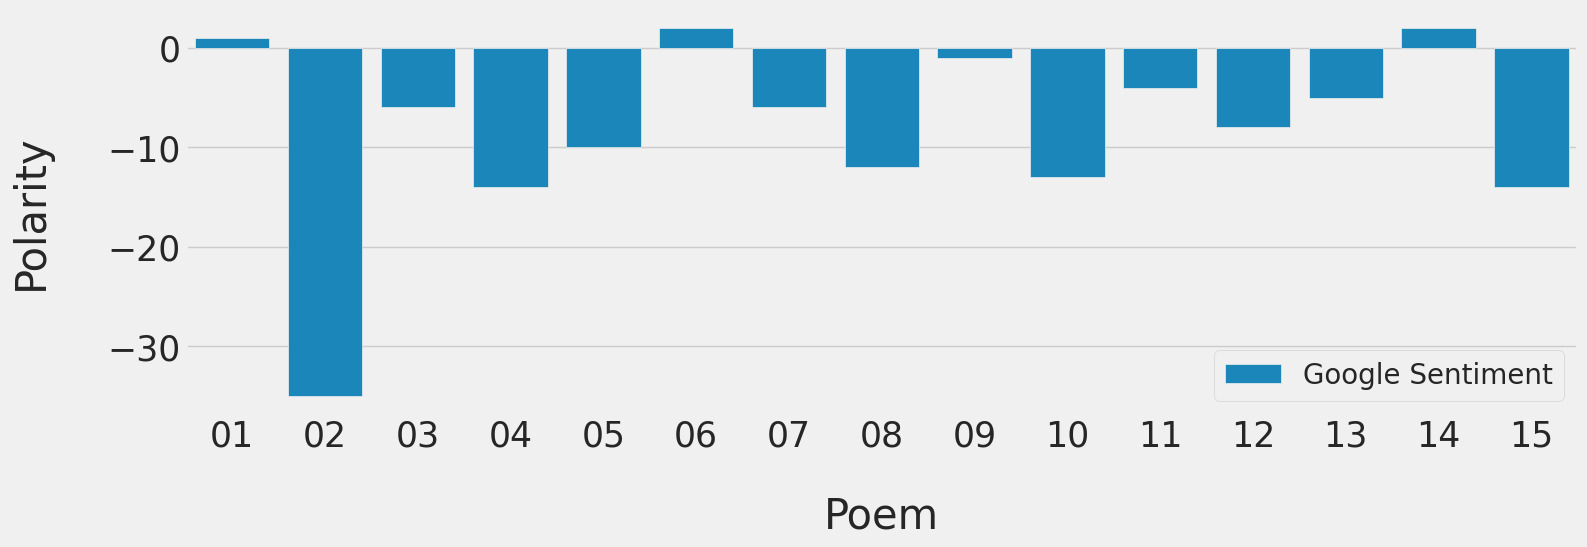

In [60]:
polarity = 0
count = 0
polarity_array = []
df_sentiments = pd.DataFrame(columns=['Poem', 'Polarity'])

for poem in poem_names:
    df_poem = pd.read_csv('results/poems/sentiment/' + 'ggl/' + poem)
    polarity = 0
    for i, row in df_poem.iterrows():
        if row['Optimistic'] == 1:
            count += 1
            polarity += 1
        if row['Thankful'] == 1:
            count += 1
            polarity += 1
        if row['Empathetic'] == 1:
            count += 1
            polarity += 1
        if row['Denial'] == 1:
            count += 1
            polarity -= 1 
        if row['Annoyed'] == 1:
            count += 1
            polarity -= 1
        if row['Sad'] == 1:
            count += 1
            polarity -= 1
        if row['Anxious'] == 1:
            count += 1
            polarity -= 1
        if row['Pessimistic'] == 1:
            count += 1
            polarity -= 1
        if row['Joking'] == 1:
            polarity += 0

    df_temp = pd.DataFrame([[poem[:2], polarity]], columns = ['Poem', 'Polarity'])
    df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index=True)

df_sentiments = df_sentiments.sort_values('Poem')
df_sentiments.reset_index()
df_sentiments.set_index('Poem')

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.barplot(x=df_sentiments['Poem'], y=df_sentiments['Polarity'], label='Google Sentiment')
p6.set_xlabel("Google Sentiment")
plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Poem', labelpad=30, fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(np.arange(0, 15, step=1), fontsize=25)
# plt.xticks(rotation=90)
plt.savefig('results/poems/graphs/google_polarity.png')

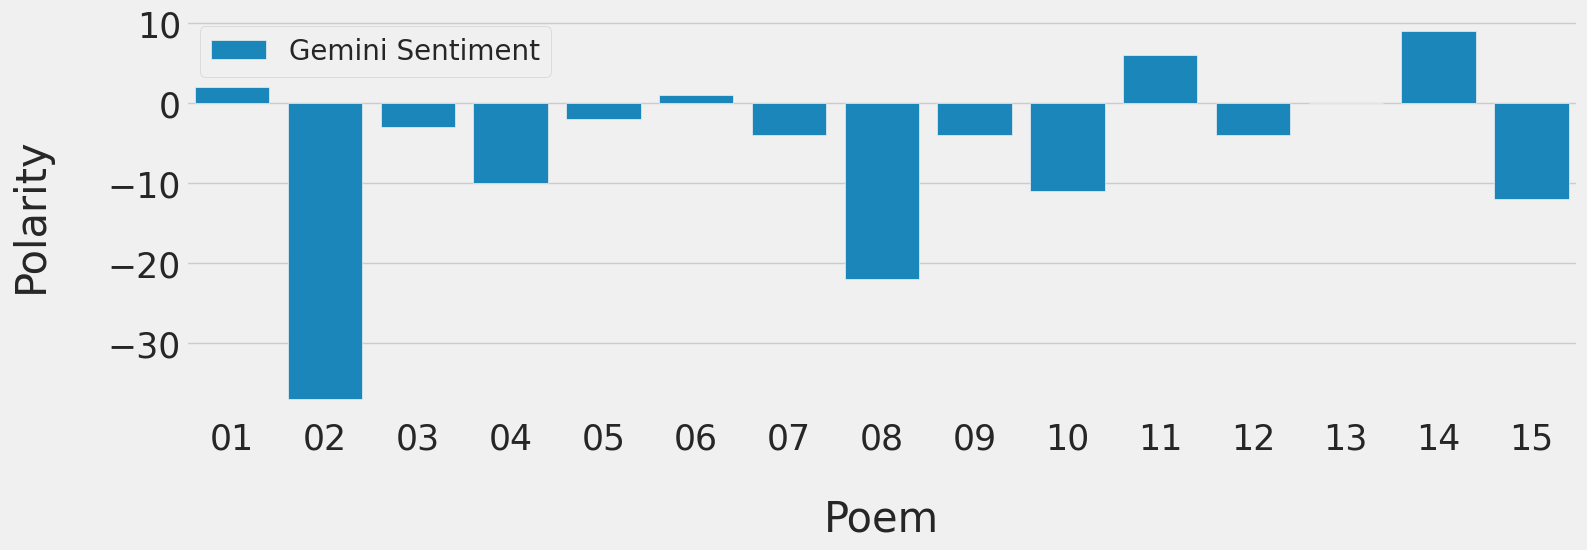

In [61]:
polarity = 0
count = 0
polarity_array = []
df_sentiments = pd.DataFrame(columns=['Poem', 'Polarity'])

for poem in poem_names:
    df_poem = pd.read_csv('results/poems/sentiment/' + 'gem/' + poem)
    polarity = 0
    for i, row in df_poem.iterrows():
        if row['Optimistic'] == 1:
            count += 1
            polarity += 1
        if row['Thankful'] == 1:
            count += 1
            polarity += 1
        if row['Empathetic'] == 1:
            count += 1
            polarity += 1
        if row['Denial'] == 1:
            count += 1
            polarity -= 1 
        if row['Annoyed'] == 1:
            count += 1
            polarity -= 1
        if row['Sad'] == 1:
            count += 1
            polarity -= 1
        if row['Anxious'] == 1:
            count += 1
            polarity -= 1
        if row['Pessimistic'] == 1:
            count += 1
            polarity -= 1
        if row['Joking'] == 1:
            polarity += 0

    df_temp = pd.DataFrame([[poem[:2], polarity]], columns = ['Poem', 'Polarity'])
    df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index=True)

df_sentiments = df_sentiments.sort_values('Poem')
df_sentiments.reset_index()
df_sentiments.set_index('Poem')

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.barplot(x=df_sentiments['Poem'], y=df_sentiments['Polarity'], label='Gemini Sentiment')
p6.set_xlabel("Gemini Sentiment")
plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Poem', labelpad=30, fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(np.arange(0, 15, step=1), fontsize=25)
# plt.xticks(rotation=90)
plt.savefig('results/poems/graphs/gemini_polarity.png')

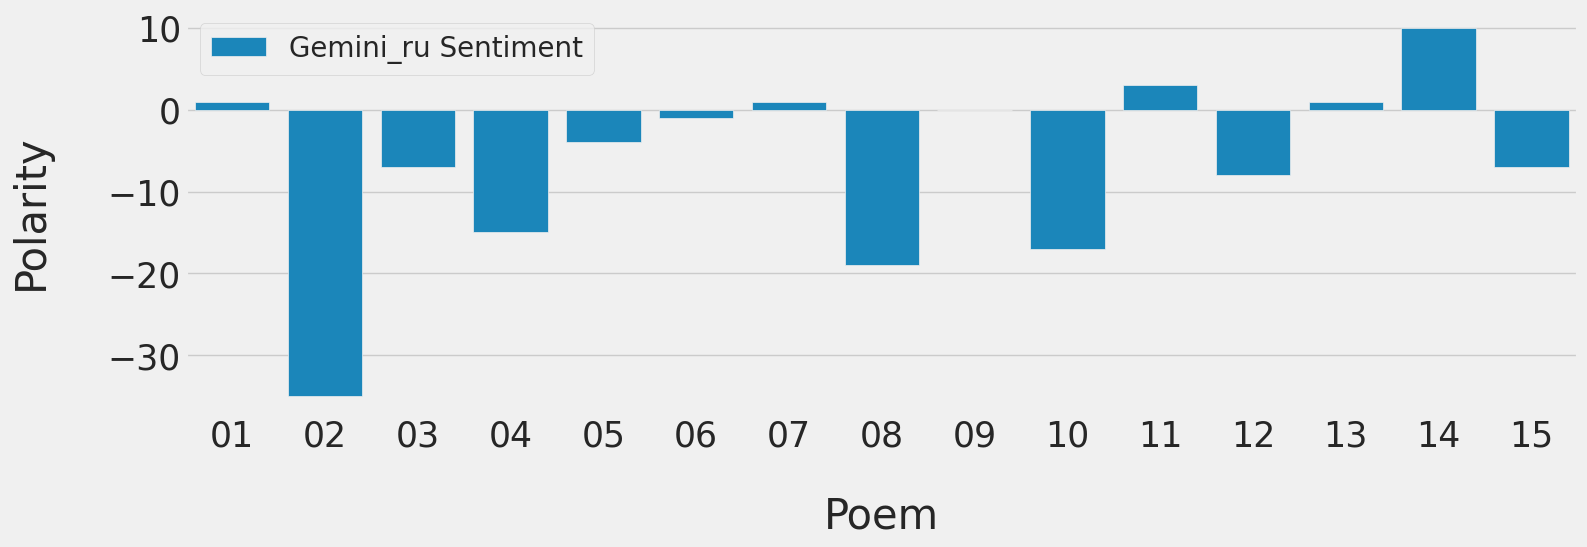

In [62]:
polarity = 0
count = 0
polarity_array = []
df_sentiments = pd.DataFrame(columns=['Poem', 'Polarity'])

for poem in poem_names:
    df_poem = pd.read_csv('results/poems/sentiment/' + 'gem_ru/' + poem)
    polarity = 0
    for i, row in df_poem.iterrows():
        if row['Optimistic'] == 1:
            count += 1
            polarity += 1
        if row['Thankful'] == 1:
            count += 1
            polarity += 1
        if row['Empathetic'] == 1:
            count += 1
            polarity += 1
        if row['Denial'] == 1:
            count += 1
            polarity -= 1 
        if row['Annoyed'] == 1:
            count += 1
            polarity -= 1
        if row['Sad'] == 1:
            count += 1
            polarity -= 1
        if row['Anxious'] == 1:
            count += 1
            polarity -= 1
        if row['Pessimistic'] == 1:
            count += 1
            polarity -= 1
        if row['Joking'] == 1:
            polarity += 0

    df_temp = pd.DataFrame([[poem[:2], polarity]], columns = ['Poem', 'Polarity'])
    df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index=True)

df_sentiments = df_sentiments.sort_values('Poem')
df_sentiments.reset_index()
df_sentiments.set_index('Poem')

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.barplot(x=df_sentiments['Poem'], y=df_sentiments['Polarity'], label='Gemini_ru Sentiment')
p6.set_xlabel("Gemini_ru Sentiment")
plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Poem', labelpad=30, fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(np.arange(0, 15, step=1), fontsize=25)
# plt.xticks(rotation=90)
plt.savefig('results/poems/graphs/remini_ru_polarity.png')

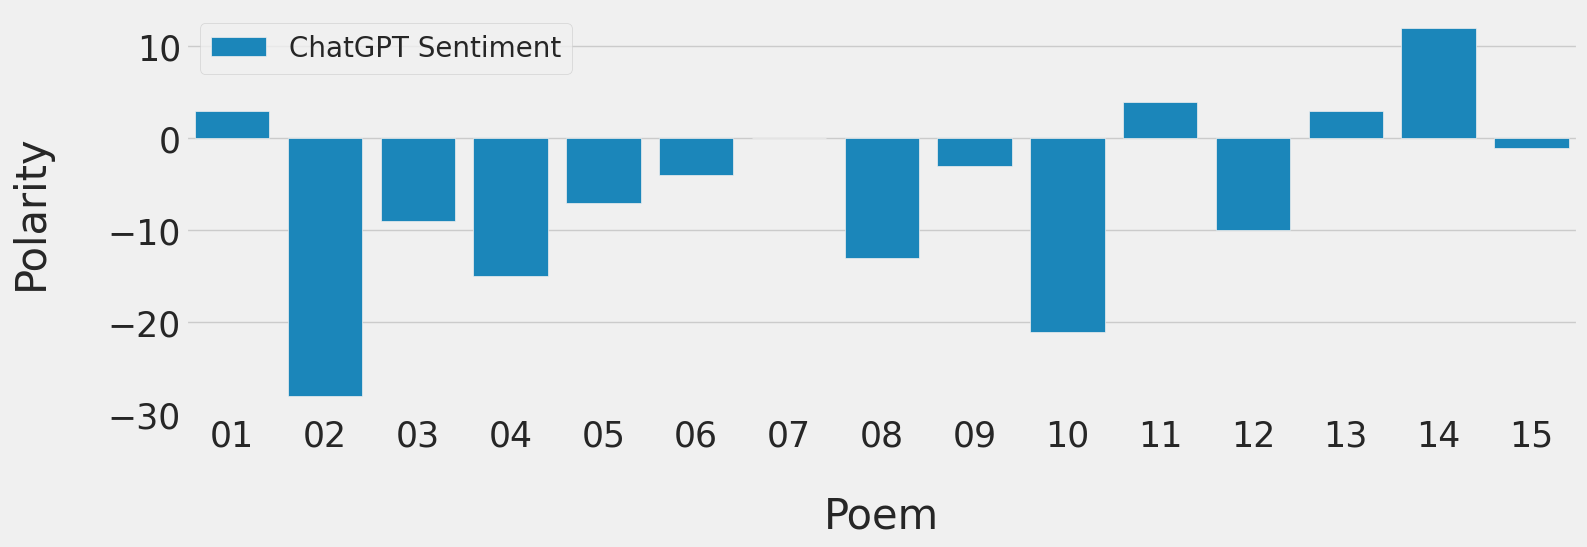

In [63]:
polarity = 0
count = 0
polarity_array = []
df_sentiments = pd.DataFrame(columns=['Poem', 'Polarity'])

for poem in poem_names:
    df_poem = pd.read_csv('results/poems/sentiment/' + 'gpt/' + poem)
    polarity = 0
    for i, row in df_poem.iterrows():
        if row['Optimistic'] == 1:
            count += 1
            polarity += 1
        if row['Thankful'] == 1:
            count += 1
            polarity += 1
        if row['Empathetic'] == 1:
            count += 1
            polarity += 1
        if row['Denial'] == 1:
            count += 1
            polarity -= 1 
        if row['Annoyed'] == 1:
            count += 1
            polarity -= 1
        if row['Sad'] == 1:
            count += 1
            polarity -= 1
        if row['Anxious'] == 1:
            count += 1
            polarity -= 1
        if row['Pessimistic'] == 1:
            count += 1
            polarity -= 1
        if row['Joking'] == 1:
            polarity += 0

    df_temp = pd.DataFrame([[poem[:2], polarity]], columns = ['Poem', 'Polarity'])
    df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index=True)

df_sentiments = df_sentiments.sort_values('Poem')
df_sentiments.reset_index()
df_sentiments.set_index('Poem')

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.barplot(x=df_sentiments['Poem'], y=df_sentiments['Polarity'], label='ChatGPT Sentiment')
p6.set_xlabel("ChatGPT Sentiment")
plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Poem', labelpad=30, fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(np.arange(0, 15, step=1), fontsize=25)
# plt.xticks(rotation=90)
plt.savefig('results/poems/graphs/chatgpt_polarity.png')

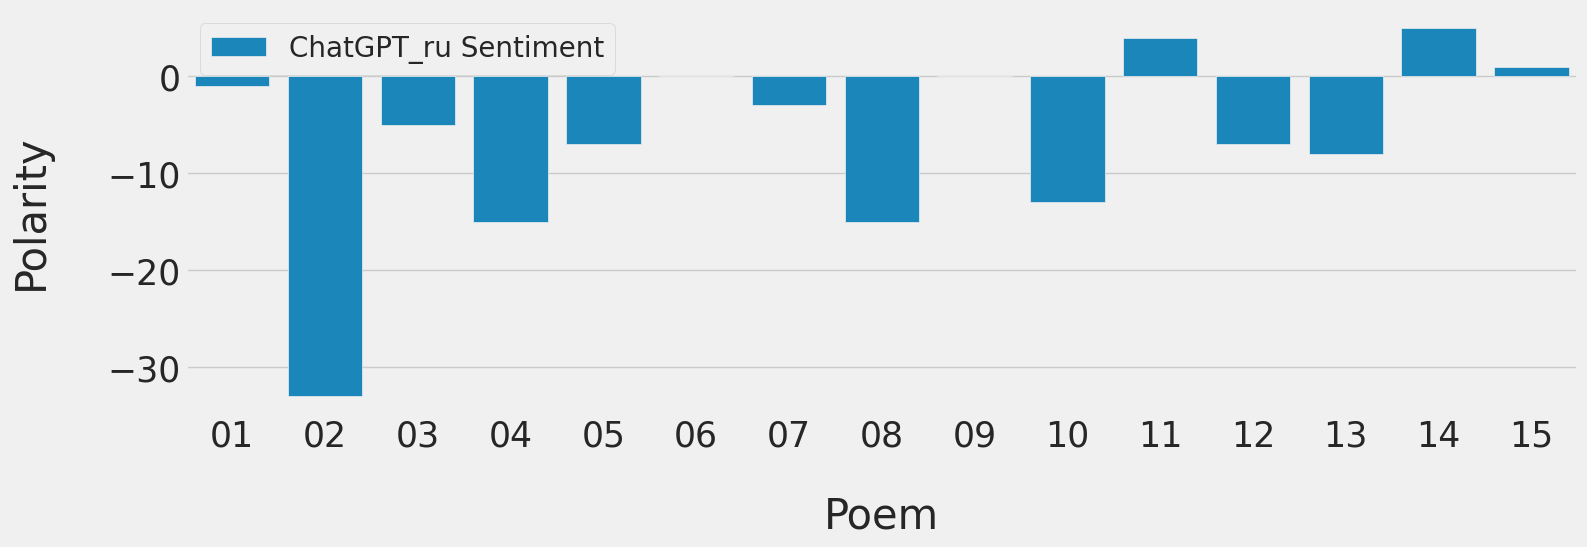

In [64]:
polarity = 0
count = 0
polarity_array = []
df_sentiments = pd.DataFrame(columns=['Poem', 'Polarity'])

for poem in poem_names:
    df_poem = pd.read_csv('results/poems/sentiment/' + 'gpt_ru/' + poem)
    polarity = 0
    for i, row in df_poem.iterrows():
        if row['Optimistic'] == 1:
            count += 1
            polarity += 1
        if row['Thankful'] == 1:
            count += 1
            polarity += 1
        if row['Empathetic'] == 1:
            count += 1
            polarity += 1
        if row['Denial'] == 1:
            count += 1
            polarity -= 1 
        if row['Annoyed'] == 1:
            count += 1
            polarity -= 1
        if row['Sad'] == 1:
            count += 1
            polarity -= 1
        if row['Anxious'] == 1:
            count += 1
            polarity -= 1
        if row['Pessimistic'] == 1:
            count += 1
            polarity -= 1
        if row['Joking'] == 1:
            polarity += 0

    df_temp = pd.DataFrame([[poem[:2], polarity]], columns = ['Poem', 'Polarity'])
    df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index=True)

df_sentiments = df_sentiments.sort_values('Poem')
df_sentiments.reset_index()
df_sentiments.set_index('Poem')

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.barplot(x=df_sentiments['Poem'], y=df_sentiments['Polarity'], label='ChatGPT_ru Sentiment')
p6.set_xlabel("ChatGPT_ru Sentiment")
plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Poem', labelpad=30, fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(np.arange(0, 15, step=1), fontsize=25)
# plt.xticks(rotation=90)
plt.savefig('results/poems/graphs/chatgpt_ru_polarity.png')

In [100]:
topic_df = pd.read_csv('results/poems/sentiment/' + 'gpt_ru/' + poem_names[0])
topic_df = topic_df.drop(['Unnamed: 0', 'Official report'], axis=1)

for poem in poem_names[1:]:
    df = pd.read_csv('results/poems/sentiment/' + 'gpt_ru/' + poem)
    df = df.drop(['Unnamed: 0', 'Official report'], axis=1)
    topic_df = pd.concat([topic_df, df], axis=0)

topic_df.head()

Tweet  \
0  I believe, I have always believed in the eternal life of the soul, a kind soul, loving its country, suffering from the fate of the country.   
1   I believe that, when the wind scatters the ashes of a kind heart across the earth, there will still burn a fervent desire for emptiness, –   
2                       It will be an oppressor of evil, always a defender of good; it will support, protect, and save the poor and the needy.   
3                                                                       Nature does not kill a kind heart, it has existed since ancient times!   
0                                                                                                   – Tell us, Elizbar, what happened at Egho?   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
1         0.0       0.0         0.0          1.0      0.0  1.0      0.0   
2         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
3         0.0       0.0         0.0          1.0      0.0  0.0      0.0   
0         0.0       0.0         0.0          0.0      0.0  0.0      0.0   

   Denial  Joking  
0     0.0     0.0  
1     0.0     0.0  
2     0.0     0.0  
3     1.0     0.0  
0     1.0     0.0

In [101]:
stop_words = stopwords.words('english')
newStopWords = []
stop_words.extend(newStopWords)

def remove_stopwords(tweets):
    return [[word for word in gensim.utils.simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))

def preprocessing(df):
    df['Tweet'] = df['Tweet'].str.lower()                                                      # Convert to lowercase
    df['Tweet'] = df['Tweet'].str.replace(r"[^a-zA-Z#]", ' ', regex=True)                     # Remove punctuations
    df['Tweet'] = df['Tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))     # Remove short words
    df['Tweet tokens'] = list(tokenize(df['Tweet']))
    df['tokens_no_stop'] = remove_stopwords(df['Tweet'])
    df['tokens_no_stop_joined'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in stop_words]))
    return df

def retrieve_text(df):
    doc = '. '.join(df['tokens_no_stop_joined'])
    return doc

def ngrams_series_func(data, n):
    wordList = re.sub("[^\w]", " ",  data).split()
    ngrams_series = (pd.Series(nltk.ngrams(wordList, n)).value_counts())[:10]
    return ngrams_series

In [102]:
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth": 1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center=90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center=0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center=9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df, this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df, this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

In [103]:
len(stop_words)

179

In [104]:
topic_df = preprocessing(topic_df)
topic_df.head()

Tweet  \
0           believe have always believed eternal life soul kind soul loving country suffering from fate country   
1  believe that when wind scatters ashes kind heart across earth there will still burn fervent desire emptiness   
2                                 will oppressor evil always defender good will support protect save poor needy   
3                                                       nature does kill kind heart existed since ancient times   
0                                                                               tell elizbar what happened egho   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
1         0.0       0.0         0.0          1.0      0.0  1.0      0.0   
2         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
3         0.0       0.0         0.0          1.0      0.0  0.0      0.0   
0         0.0       0.0         0.0          0.0      0.0  0.0      0.0   

   Denial  Joking  \
0     0.0     0.0   
1     0.0     0.0   
2     0.0     0.0   
3     1.0     0.0   
0     1.0     0.0   

                                                                                                                     Tweet tokens  \
0             [believe, have, always, believed, eternal, life, soul, kind, soul, loving, country, suffering, from, fate, country]   
1  [believe, that, when, wind, scatters, ashes, kind, heart, across, earth, there, will, still, burn, fervent, desire, emptiness]   
2                                      [will, oppressor, evil, always, defender, good, will, support, protect, save, poor, needy]   
3                                                               [nature, does, kill, kind, heart, existed, since, ancient, times]   
0                                                                                           [tell, elizbar, what, happened, egho]   

                                                                                            tokens_no_stop  \
0  [believe, always, believed, eternal, life, soul, kind, soul, loving, country, suffering, fate, country]   
1    [believe, wind, scatters, ashes, kind, heart, across, earth, still, burn, fervent, desire, emptiness]   
2                           [oppressor, evil, always, defender, good, support, protect, save, poor, needy]   
3                                              [nature, kill, kind, heart, existed, since, ancient, times]   
0                                                                          [tell, elizbar, happened, egho]   

                                                                       tokens_no_stop_joined  
0  believe always believed eternal life soul kind soul loving country suffering fate country  
1    believe wind scatters ashes kind heart across earth still burn fervent desire emptiness  
2                        oppressor evil always defender good support protect save poor needy  
3                                         nature kill kind heart existed since ancient times  
0                                                                 tell elizbar happened egho

In [105]:
text = retrieve_text(topic_df)
text.split('. ')

['believe always believed eternal life soul kind soul loving country suffering fate country',
 'believe wind scatters ashes kind heart across earth still burn fervent desire emptiness',
 'oppressor evil always defender good support protect save poor needy',
 'nature kill kind heart existed since ancient times',
 'tell elizbar happened egho',
 'chechens attack courtyard bakur fortress',
 'want sorrows tear heart apart',
 'bakur boast bravery',
 'life grave',
 'abase',
 'tell truth praise',
 'hold shoulder soul bitter',
 'seen bakur actions eyes',
 'heart torn apart fall alive enemy hands',
 'thoughts rise poison throat',
 'want lift head straighten back',
 'worry',
 'ashamed shameful',
 'also know heard tale kilo kavada',
 'condemned thank spoke',
 'tell detail',
 'large enemy army came surrounded fence',
 'fought rifles seven days killed many',
 'women prepared medicines truly worthy praise',
 'eighth ammunition completely depleted',
 'considered efforts lost',
 'sleepless hungry thirs

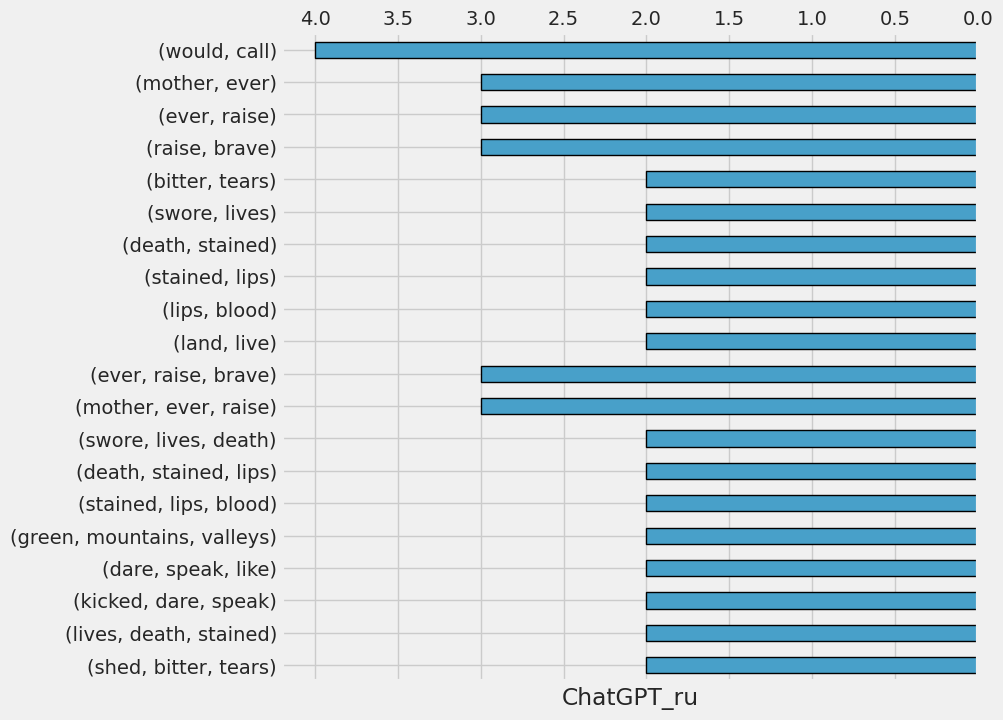

In [106]:
bigram1 = ngrams_series_func(text, 2)
trigram1 = ngrams_series_func(text, 3)
ngram1 = pd.concat([bigram1, trigram1])

plt.rcParams.update({'font.size': 14})
fig, ax=plt.subplots(1,1, figsize=(8,8))
barh_ax = ax

ngram1[::-1].plot.barh(ax=barh_ax, color=barcolors[3], **barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('ChatGPT_ru')
barh_ax.set_ylabel('', fontsize=50)
plt.savefig('results/poems/ngrams_ru.png')

In [107]:
topic_df = pd.read_csv('results/poems/sentiment/' + 'gpt_ru/' + poem_names[0])
topic_df = topic_df.drop(['Unnamed: 0', 'Official report'], axis=1)

for poem in poem_names[1:]:
    df = pd.read_csv('results/poems/sentiment/' + 'gpt_ru/' + poem)
    df = df.drop(['Unnamed: 0', 'Official report'], axis=1)
    topic_df = pd.concat([topic_df, df], axis=0)

In [108]:
stop_words = stopwords.words('english')

def remove_stopwords(tweets):
    return [[word for word in gensim.utils.simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))

def preprocessing(df):
    df['Tweet'] = df['Tweet'].str.lower()                                                      # Convert to lowercase
    df['Tweet'] = df['Tweet'].str.replace(r'[^a-zA-Z#]', ' ', regex=True)                                   # Remove punctuations
    df['Tweet'] = df['Tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))     # Remove short words
    df['Tweet tokens'] = list(tokenize(df['Tweet']))
    df['tokens_no_stop'] = remove_stopwords(df['Tweet'])
    df['tokens_no_stop_joined'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in stop_words]))
    return df

def retrieve_text(df):
    doc = '. '.join(df['tokens_no_stop_joined'])
    return doc

def ngrams_series_func(data, n):
    wordList = re.sub("[^\w]", " ",  data).split()
    ngrams_series = (pd.Series(nltk.ngrams(wordList, n)).value_counts())[:10]
    return ngrams_series

In [109]:
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df, this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df, this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)


In [110]:
topic_df = preprocessing(topic_df)
topic_df.head()

Tweet  \
0           believe have always believed eternal life soul kind soul loving country suffering from fate country   
1  believe that when wind scatters ashes kind heart across earth there will still burn fervent desire emptiness   
2                                 will oppressor evil always defender good will support protect save poor needy   
3                                                       nature does kill kind heart existed since ancient times   
0                                                                               tell elizbar what happened egho   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
1         0.0       0.0         0.0          1.0      0.0  1.0      0.0   
2         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
3         0.0       0.0         0.0          1.0      0.0  0.0      0.0   
0         0.0       0.0         0.0          0.0      0.0  0.0      0.0   

   Denial  Joking  \
0     0.0     0.0   
1     0.0     0.0   
2     0.0     0.0   
3     1.0     0.0   
0     1.0     0.0   

                                                                                                                     Tweet tokens  \
0             [believe, have, always, believed, eternal, life, soul, kind, soul, loving, country, suffering, from, fate, country]   
1  [believe, that, when, wind, scatters, ashes, kind, heart, across, earth, there, will, still, burn, fervent, desire, emptiness]   
2                                      [will, oppressor, evil, always, defender, good, will, support, protect, save, poor, needy]   
3                                                               [nature, does, kill, kind, heart, existed, since, ancient, times]   
0                                                                                           [tell, elizbar, what, happened, egho]   

                                                                                            tokens_no_stop  \
0  [believe, always, believed, eternal, life, soul, kind, soul, loving, country, suffering, fate, country]   
1    [believe, wind, scatters, ashes, kind, heart, across, earth, still, burn, fervent, desire, emptiness]   
2                           [oppressor, evil, always, defender, good, support, protect, save, poor, needy]   
3                                              [nature, kill, kind, heart, existed, since, ancient, times]   
0                                                                          [tell, elizbar, happened, egho]   

                                                                       tokens_no_stop_joined  
0  believe always believed eternal life soul kind soul loving country suffering fate country  
1    believe wind scatters ashes kind heart across earth still burn fervent desire emptiness  
2                        oppressor evil always defender good support protect save poor needy  
3                                         nature kill kind heart existed since ancient times  
0                                                                 tell elizbar happened egho

In [111]:
df_optimistic = topic_df[topic_df['Optimistic'] == 1]
df_pessimistic = topic_df[topic_df['Pessimistic'] == 1]
df_denial = topic_df[topic_df['Denial'] == 1]
df_annoyed = topic_df[topic_df['Annoyed'] == 1]
df_thankful = topic_df[topic_df['Thankful'] == 1]
df_empathetic = topic_df[topic_df['Empathetic'] == 1]
df_anxious = topic_df[topic_df['Anxious'] == 1]
df_sad =  topic_df[topic_df['Sad'] == 1]
df_joking = topic_df[topic_df['Joking'] == 1]

In [112]:
text_optimistic = '. '.join(df_optimistic.tokens_no_stop_joined)
text_pessimistic = '. '.join(df_pessimistic.tokens_no_stop_joined)
text_denial = '. '.join(df_denial.tokens_no_stop_joined)
text_annoyed = '. '.join(df_annoyed.tokens_no_stop_joined)
text_thankful = '. '.join(df_thankful.tokens_no_stop_joined)
text_empathetic = '. '.join(df_empathetic.tokens_no_stop_joined)
text_anxious = '. '.join(df_anxious.tokens_no_stop_joined)
text_sad = '. '.join(df_sad.tokens_no_stop_joined)
text_joking = '. '.join(df_joking.tokens_no_stop_joined)

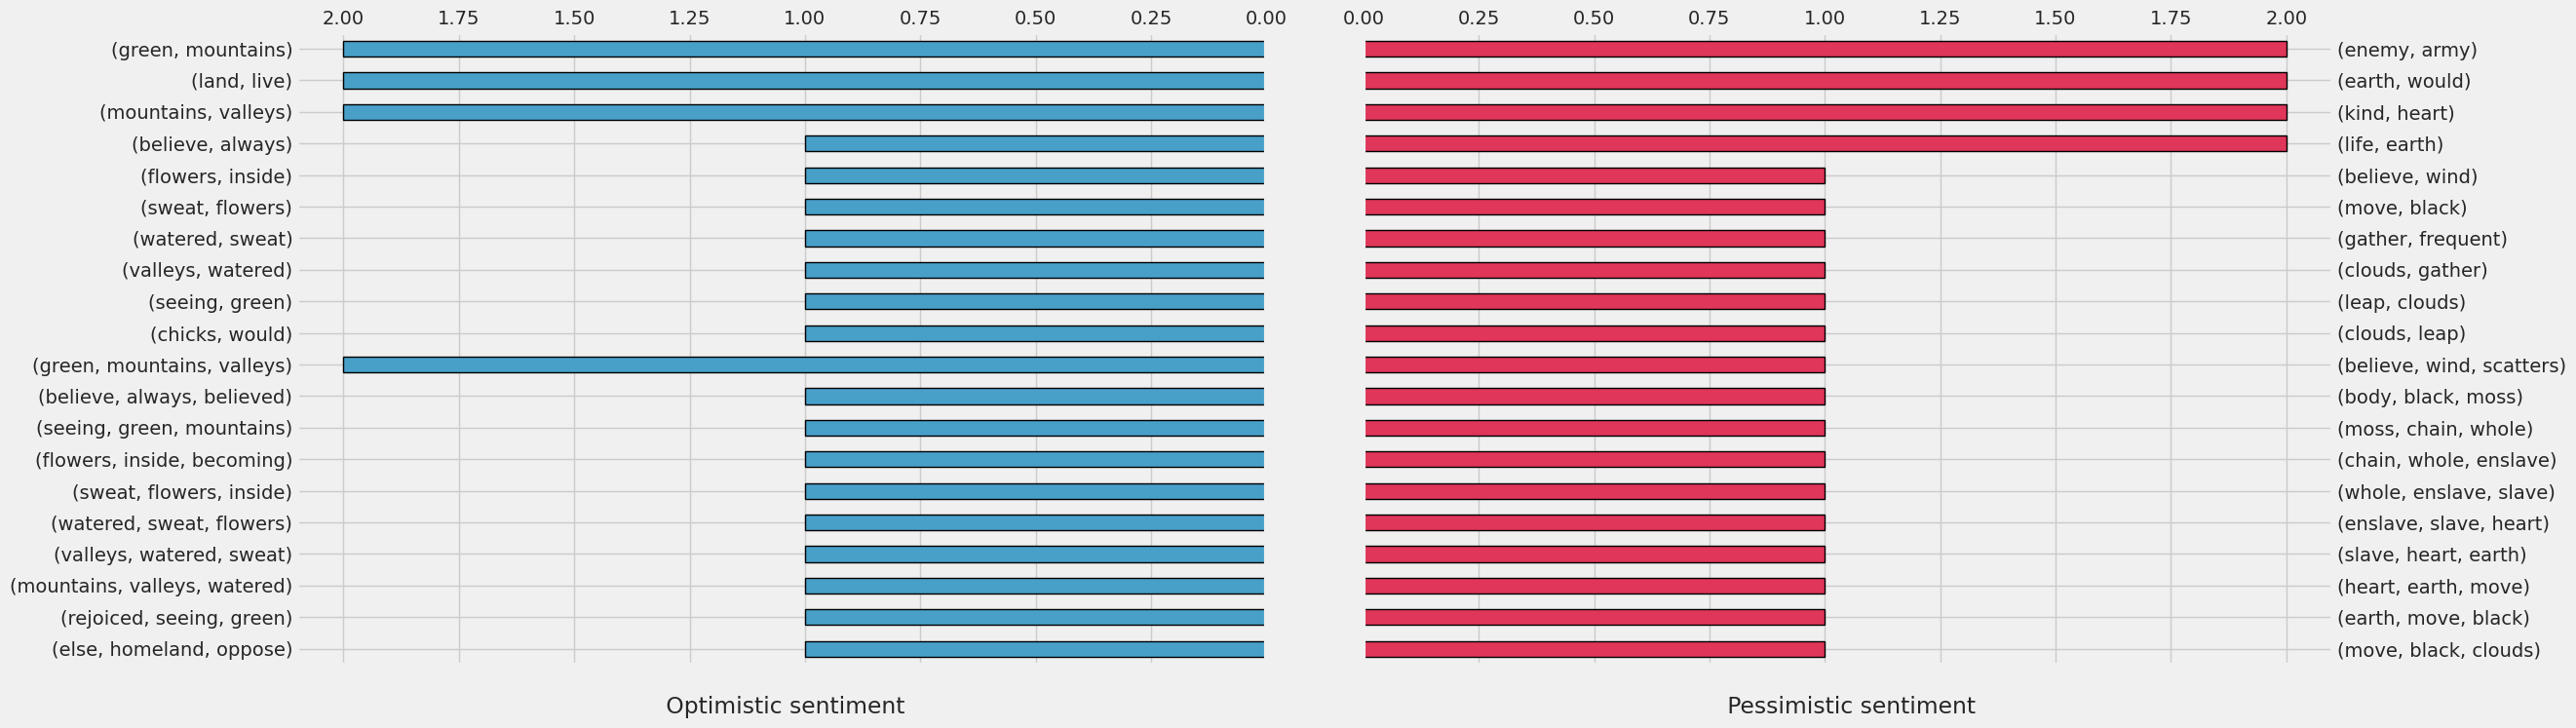

In [113]:
bigram1 = ngrams_series_func(text_optimistic, 2)
trigram1 = ngrams_series_func(text_optimistic, 3)
bigram2 = ngrams_series_func(text_pessimistic, 2)
trigram2 = ngrams_series_func(text_pessimistic, 3)

ngram1 = pd.concat([bigram1, trigram1])
ngram2 = pd.concat([bigram2, trigram2])

plt.rcParams.update({'font.size': 14})
fig, ax=plt.subplots(1, 2, figsize=(24, 8), gridspec_kw = {'width_ratios':[1,1], 'wspace': 0.1, 'hspace': 0.1})

barh_ax = ax[0]
ngram1[::-1].plot.barh(ax=barh_ax, color=barcolors[3], **barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('\n Optimistic sentiment')
barh_ax.set_ylabel('',fontsize=50)

barh_ax = ax[1]
ngram2[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
barh_ax.set_ylabel('', fontsize=50)
barh_ax.set_xlabel('\n Pessimistic sentiment')
plt.savefig('results/poems/graphs/gpt_ru_pos_neg_pngrams.png')

In [114]:
sentiments = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Joking']

def return_sentiments(data, row):
    text = ''
    for sentiment in sentiments:
        if data[sentiment][row] == 1:
            text += sentiment
            text += ', '
    return text

In [116]:
sentiments = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Joking']
data = pd.DataFrame(columns=[
    'Poem', 'Verse No.', 'Author', 'Verse', 'Predicted Sentiments', 
    'Hewitt - Google', 'Hewitt - Gemini', 'Hewitt - Gemini_ru', 'Hewitt - ChatGPT', 'Hewitt - ChatGPT_ru'
])
count = 0

for poem in poem_names:
    semantic_comparsion = pd.read_csv('results/poems/similarity/cosine_similarity_ru.csv')
    
    df_ggl = pd.read_csv('results/poems/sentiment/' + 'ggl/' + poem)
    df_ggl = df_ggl.drop(['Unnamed: 0', 'Official report'], axis=1)
    df_gem = pd.read_csv('results/poems/sentiment/' + 'gem/' + poem)
    df_gem = df_gem.drop(['Unnamed: 0', 'Official report'], axis=1)
    df_gem_ru = pd.read_csv('results/poems/sentiment/' + 'gem_ru/' + poem)
    df_gem_ru = df_gem_ru.drop(['Unnamed: 0', 'Official report'], axis=1)
    df_gpt = pd.read_csv('results/poems/sentiment/' + 'gpt/' + poem)
    df_gpt = df_gpt.drop(['Unnamed: 0', 'Official report'], axis=1)
    df_gpt_ru = pd.read_csv('results/poems/sentiment/' + 'gpt_ru/' + poem)
    df_gpt_ru = df_gpt_ru.drop(['Unnamed: 0', 'Official report'], axis=1)    

    for ii in range(5 * df_ggl.shape[0]):
        
        if ii % 5 == 0:
            pr_sentiments = return_sentiments(df_ggl, ii // 5)
            dict2 = {
                'Poem': [poem], 
                'Verse No.': [ii // 5 + 1], 
                'Author':['Google'],
                'Verse': [df_ggl['Tweet'][ii // 5]], 
                'Predicted Sentiments': [pr_sentiments],
                'Hewitt - Google': [semantic_comparsion['Hewitt - Google'][ii // 5]], 
                'Hewitt - Gemini': [semantic_comparsion['Hewitt - Gemini'][ii // 5]],
                'Hewitt - Gemini_ru': [semantic_comparsion['Hewitt - Gemini_ru'][ii // 5]],
                'Hewitt - ChatGPT': [semantic_comparsion['Hewitt - ChatGPT'][ii // 5]],
                'Hewitt - ChatGPT_ru': [semantic_comparsion['Hewitt - ChatGPT_ru'][ii // 5]]
            }
            df_temp = pd.DataFrame(dict2)
            data = pd.concat([data, df_temp], ignore_index=True)

        elif ii % 5 == 1:
            pr_sentiments = return_sentiments(df_gem, ii // 5)
            dict2 = {
                'Poem': [' '], 
                'Verse No.': [ii // 5 + 1], 
                'Author':['Gemini'], 
                'Verse': [df_gem['Tweet'][ii // 5]], 
                'Predicted Sentiments': [pr_sentiments],
                'Hewitt - Google': [' '], 
                'Hewitt - Gemini': [' '],
                'Hewitt - Gemini_ru': [' '],
                'Hewitt - ChatGPT': [' '],
                'Hewitt - ChatGPT_ru': [' ']
            }
            df_temp = pd.DataFrame(dict2)
            data = pd.concat([data, df_temp], ignore_index=True)

        elif ii % 5 == 2:
            pr_sentiments = return_sentiments(df_gem_ru, ii // 5)
            dict2 = {
                'Poem': [' '], 
                'Verse No.': [ii // 5 + 1], 
                'Author':['Gemini_ru'], 
                'Verse': [df_gem_ru['Tweet'][ii // 5]], 
                'Predicted Sentiments': [pr_sentiments],
                'Hewitt - Google': [' '], 
                'Hewitt - Gemini': [' '],
                'Hewitt - Gemini_ru': [' '],
                'Hewitt - ChatGPT': [' '],
                'Hewitt - ChatGPT_ru': [' ']
            }
            df_temp = pd.DataFrame(dict2)
            data = pd.concat([data, df_temp], ignore_index=True)

        elif ii % 5 == 3:
            pr_sentiments = return_sentiments(df_gpt, ii // 5)
            dict2 = {
                'Poem': [' '], 
                'Verse No.': [ii // 5 + 1], 
                'Author':['ChatGPT'], 
                'Verse': [df_gpt['Tweet'][ii // 5]], 
                'Predicted Sentiments': [pr_sentiments],
                'Hewitt - Google': [' '], 
                'Hewitt - Gemini': [' '],
                'Hewitt - Gemini_ru': [' '],
                'Hewitt - ChatGPT': [' '],
                'Hewitt - ChatGPT_ru': [' ']
            }
            df_temp = pd.DataFrame(dict2)
            data = pd.concat([data, df_temp], ignore_index=True)


        else:
            pr_sentiments = return_sentiments(df_gpt_ru, ii // 5)
            dict2 = {
                'Poem': [' '], 
                'Verse No.': [ii // 5 + 1], 
                'Author':['ChatGPT_ru'], 
                'Verse': [df_gpt_ru['Tweet'][ii // 5]], 
                'Predicted Sentiments': [pr_sentiments],
                'Hewitt - Google': [' '], 
                'Hewitt - Gemini': [' '],
                'Hewitt - Gemini_ru': [' '],
                'Hewitt - ChatGPT': [' '],
                'Hewitt - ChatGPT_ru': [' ']
            }
            df_temp = pd.DataFrame(dict2)
            data=pd.concat([data, df_temp], ignore_index=True)

data

Poem Verse No.      Author  \
0      01_i_believe_i_always_have_believed.md         1      Google   
1                                                     1      Gemini   
2                                                     1   Gemini_ru   
3                                                     1     ChatGPT   
4                                                     1  ChatGPT_ru   
...                                       ...       ...         ...   
1450  15_thrush_its_the_same_song_you_sing.md        34      Google   
1451                                                 34      Gemini   
1452                                                 34   Gemini_ru   
1453                                                 34     ChatGPT   
1454                                                 34  ChatGPT_ru   

                                                                                                                                                           Verse  \
0                                           I believe, there are always lands eternal life of the soul, Good, country lover, Ulcer from the fate of the country.   
1                  I believe, I've always believed In the eternal life of the soul, Of the good, the lover of the country, The one pained by the country's fate.   
2                              I believe, I have always believed in the eternal life of the soul, in goodness, in love for my homeland, in the pain of its fate.   
3     I believe, I have always believed in the eternal life of the soul, of the good, the lover of the homeland, the one suffering from the fate of the country.   
4                    I believe, I have always believed in the eternal life of the soul, a kind soul, loving its country, suffering from the fate of the country.   
...                                                                                                                                                          ...   
1450                                                                                                          I miss you in many ways I can't praise you enough!   
1451                                                                                                         I miss you in many and in many I cannot praise you!   
1452                                                                                                                  Many miss you, and many cannot praise you!   
1453                                                                                                       Many long for you, and many cannot praise you enough!   
1454                                                                                                 I miss you in many ways and in many ways cannot praise you!   

          Predicted Sentiments Hewitt - Google Hewitt - Gemini  \
0                 Empathetic,         0.534823        0.741352   
1                 Empathetic,                                    
2     Optimistic, Empathetic,                                    
3     Optimistic, Empathetic,                                    
4     Optimistic, Empathetic,                                    
...                        ...             ...             ...   
1450                     Sad,         0.392336        0.652793   
1451                     Sad,                                    
1452                     Sad,                                    
1453              Empathetic,                                    
1454                     Sad,                                    

     Hewitt - Gemini_ru Hewitt - ChatGPT Hewitt - ChatGPT_ru  
0              0.799305         0.767628            0.783258  
1                                                             
2                                                             
3                                                             
4                                                             
...                 ...              ...        